### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000023548B540D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 4: ML modeling 

ASSUMPTION: run for datasets ESC-10, BDLib2 and US8k:

* *01_Feature_extraction_exploration.ipynb*
* *02_PreProcessing_and_ML_modeling.ipynb* 

And run for the new dataset US8K_AV:
* *03_New_dataset_US8K_AV.ipynb*
* *03_New_dataset_US8K_AV_silence_audio.ipynb*

***

## Importe modules

In [2]:
import mimetypes
import warnings
import os
import pickle
import time
import random

import pandas          as pd
import numpy           as np
import seaborn         as sns

from matplotlib  import pyplot as plt

from matplotlib.patches        import Patch
from collections               import Counter
from sklearn.model_selection   import StratifiedKFold, StratifiedShuffleSplit, KFold, learning_curve, cross_val_score
from sklearn.model_selection   import GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn                   import preprocessing
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import GaussianNB
from sklearn.svm               import SVC
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn                   import metrics


In [3]:
# Solution to play .ogg files in the IPython 
# https://stackoverflow.com/questions/39077987/ipython-display-audio-cannot-correctly-handle-ogg-file-type

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

In [4]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '04_ML_modeling_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

In [5]:
current_path

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master'

## Loading the dataset


In [6]:
# Select the dataset

opc = 0
while str(opc) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")


    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = '1'
    N_SPLITS    = 5

    pkl_features           = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'
    N_SPLITS    = 3

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    N_SPLITS    = 10
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    

if opc == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV_merged.csv'
    fold        = '1'
    N_SPLITS    = 10
   
    pkl_features          = 'US8K_AV_features_original.pkl'
    pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 4


In [7]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [8]:
from MT_loadDataset import loadDataset

In [9]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
silence              550
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4908
Total number of AUDIO files...........:  4908


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path
0,5,fold5,"[0, 0, 0, 1, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav
1,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav
2,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav
3,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav
4,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav
...,...,...,...,...,...,...
4903,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_10.wav
4904,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_11.wav
4905,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_12.wav
4906,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_8.wav


In [10]:
DB.dtypes

Fold                  int64
Folder_name          object
Class_OHEV           object
Class_categorical    object
File_name            object
Path                 object
dtype: object

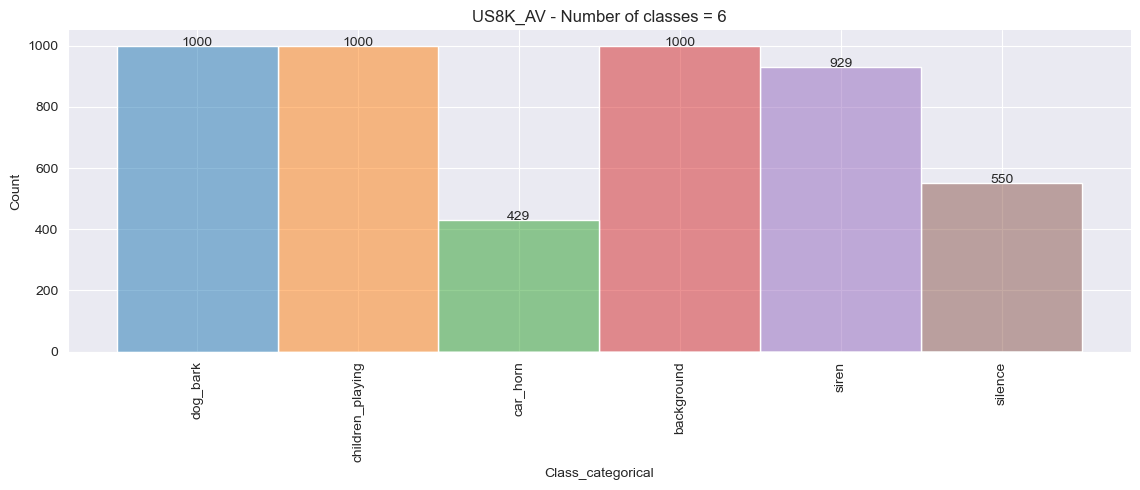

In [11]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [12]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_features))
    model_surname = '_original'

if opc == 2:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_aug_features))
    model_surname = '_augmented'

if opc == 3:
    DB_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
    model_surname = '_windowed'


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K only windowed)

Select the dataset: 3


In [13]:
DB_from_pkl.dtypes

Audio                  object
Class_categorical      object
Class_OHEV             object
Fold                   object
RMSE                  float64
                       ...   
TONNETZ_6             float64
TONNETZ_std_6         float64
TONNETZ_median_6      float64
TONNETZ_skew_6        float64
TONNETZ_kurtosis_6    float64
Length: 379, dtype: object

## Input split

In [14]:
# Separate 1 fold for validation and create a DB for the training / testing according to the datasets specification

DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()

In [15]:
print(len(DB_from_pkl_VAL))
print(len(DB_from_pkl_TRN))
print('Total: ', len(DB_from_pkl_VAL) + len(DB_from_pkl_TRN),'\n')

3346
31010
Total:  34356 



In [16]:
DB_from_pkl_VAL

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
231,"[6.402111e-05, 8.269498e-05, 5.2123058e-05, 7.1509836e-05, 3.3138364e-05, -6.1828905e-07, -8.950657e-05, -9.0291964e...",dog_bark,"[0, 0, 0, 1, 0, 0]",1,0.020142,0.031516,1152.318462,1898.286145,2047.611861,0.000215,...,-0.025755,0.022838,-0.026786,-0.052399,0.615014,0.008609,0.019867,0.005833,0.230194,-0.774566
232,"[0.0005136457, 0.00041881658, 0.00034897702, 0.00021603762, 0.0002278979, 0.00011100468, 0.00010083006, 0.0001630317...",dog_bark,"[0, 0, 0, 1, 0, 0]",1,0.035680,0.036821,1237.588550,1949.387843,2185.620117,0.000149,...,-0.019544,0.025159,-0.019644,-0.651683,0.800014,0.007915,0.018672,0.009202,0.529034,0.970660
233,"[-5.3512427e-05, 2.2222208e-05, 2.7161423e-05, 0.00017825539, 0.00032240857, 0.00041231932, 0.0005614782, 0.00053010...",dog_bark,"[0, 0, 0, 1, 0, 0]",1,0.036087,0.045854,1422.395537,2117.020765,2954.942738,0.000164,...,-0.054370,0.025735,-0.047586,-1.318172,1.632758,-0.027509,0.030452,-0.029692,0.291676,-0.927084
234,"[-9.721824e-05, -0.0002176053, -0.00031682133, -0.00042641407, -0.00044769727, -0.00042776082, -0.00044338158, -0.00...",dog_bark,"[0, 0, 0, 1, 0, 0]",1,0.000778,0.040949,1877.232022,2785.436746,4904.676403,0.000262,...,-0.030969,0.007624,-0.032476,0.155556,-0.770907,-0.012053,0.031560,-0.005922,-0.290679,-1.082696
235,"[0.00023775743, 0.00023206181, 0.00023593163, 0.00017538742, 0.00011133426, 0.00021567091, 0.00011633049, 8.274122e-...",dog_bark,"[0, 0, 0, 1, 0, 0]",1,0.076167,0.042880,1592.015997,2199.860601,3819.696600,0.000478,...,0.000732,0.044018,-0.017289,1.031027,0.270565,0.010252,0.030058,0.002691,1.003930,1.476461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30837,"[0.0004533253, 0.0004609438, 0.00043082816, 0.0004680011, 0.00044090266, 0.0004159223, 0.00044615153, 0.00033951446,...",silence,"[0, 0, 0, 0, 1, 0]",1,0.000545,0.027011,1932.701213,2600.971775,4890.239369,0.000228,...,-0.047902,0.003977,-0.049310,1.166108,0.280281,0.218008,0.039113,0.233184,-2.282457,4.259912
30838,"[0.00017956269, 0.00035041687, 0.00028244377, 0.00029154716, 0.00042117725, 0.00041305454, 0.00040095835, 0.00039254...",silence,"[0, 0, 0, 0, 1, 0]",1,0.000545,0.027011,1932.380749,2599.898854,4890.973455,0.000228,...,-0.047818,0.003966,-0.049161,1.116917,0.244833,0.217326,0.039534,0.232674,-2.273420,4.254254
30839,"[-0.00011860943, -6.20941e-05, -8.068766e-05, -2.62707e-05, 2.1147845e-05, 7.191092e-05, 0.00010657643, 0.0001931514...",silence,"[0, 0, 0, 0, 1, 0]",1,0.000545,0.027055,1936.112437,2603.065093,4897.335538,0.000228,...,-0.047917,0.003814,-0.049189,1.117914,0.429509,0.217507,0.038939,0.232747,-2.254844,4.165775
30840,"[-0.00036955072, -0.00043088698, -0.00031412364, -0.00035251322, -0.00031178963, -0.00029819133, -0.00025626598, -0....",silence,"[0, 0, 0, 0, 1, 0]",1,0.000545,0.027055,1939.198192,2604.980771,4902.963534,0.000228,...,-0.047851,0.004228,-0.049385,1.336005,0.948563,0.217716,0.039959,0.233470,-2.309939,4.438597


In [17]:
DB_from_pkl_TRN

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,0.117183,0.129483,2069.471399,1734.789901,2861.958452,0.000172,...,-0.027402,0.036064,-0.027793,-0.105702,-0.542892,-0.046177,0.025644,-0.046785,0.461191,-0.338882
1,"[-0.015428771, -0.0064468235, -0.002025701, -0.009768408, -0.020482529, -0.03246226, -0.046539657, -0.050950672, -0....",dog_bark,"[0, 0, 0, 1, 0, 0]",5,0.111724,0.131570,2098.418718,1743.608984,2885.449219,0.000047,...,-0.024680,0.026742,-0.021896,-0.009029,-0.613116,-0.026347,0.026433,-0.030688,0.414979,-0.840459
2,"[-0.17165461, -0.1961453, -0.2095497, -0.116395764, 0.02499168, 0.15181583, 0.2456393, 0.24304995, 0.1697193, 0.0706...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,0.124646,0.131459,2096.616414,1747.412264,2877.618963,0.000173,...,-0.022529,0.029269,-0.019908,-0.041418,-0.757713,-0.045096,0.023640,-0.045384,0.629947,0.096665
3,"[-0.004147315, -0.014180049, -0.016550057, -0.017083425, -0.010863152, -0.0018686495, 0.006234308, 0.00725661, 0.005...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,0.110741,0.131658,2093.378630,1736.615179,2873.214444,0.000026,...,-0.029242,0.026361,-0.024858,-0.293476,-0.509338,-0.020052,0.024617,-0.025407,0.554764,-0.364067
4,"[-0.047271818, -0.08598116, -0.08329079, -0.15244874, -0.21367016, -0.26584676, -0.19677721, -0.17195633, -0.0841544...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,0.125728,0.131836,2105.951159,1750.491381,2885.693914,0.000831,...,-0.027311,0.028995,-0.029214,-0.145633,-0.282959,-0.032483,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34351,"[-0.0013713251, -0.0009226998, -0.0006403711, -0.0005783211, -0.0006910372, -0.00091834716, -0.0010323625, -0.000976...",silence,"[0, 0, 0, 0, 1, 0]",9,0.002225,0.028387,920.881858,1319.656082,2078.932884,0.067512,...,0.003492,0.011031,0.003055,0.220017,-0.689318,-0.025411,0.013994,-0.018363,-0.710840,-0.875780
34352,"[0.0015545484, 0.001670274, 0.0018922735, 0.0021141772, 0.002221069, 0.002072654, 0.0018563501, 0.0018253133, 0.0019...",silence,"[0, 0, 0, 0, 1, 0]",9,0.002441,0.028187,882.948049,1265.997091,1975.426691,0.081268,...,0.003582,0.011518,0.008667,-1.235108,0.148265,-0.004595,0.010918,0.001000,-0.683456,-0.967157
34353,"[-0.0010607778, -0.0006731042, -0.00053357193, -0.0006793465, -0.00088371243, -0.00095680775, -0.0009278627, -0.0008...",silence,"[0, 0, 0, 0, 1, 0]",9,0.002433,0.029918,888.433237,1238.984897,1956.585138,0.069162,...,-0.024985,0.025471,-0.025156,-0.231457,-1.474232,0.003198,0.016168,0.004923,0.232408,-1.142400
34354,"[-0.00025361695, -0.00036392454, -0.0002459652, 0.000116177835, 0.0004521357, 0.0005208538, 0.0003343413, 5.40631e-0...",silence,"[0, 0, 0, 0, 1, 0]",9,0.002244,0.032737,898.209632,1196.113306,1924.040638,0.051693,...,-0.025264,0.018577,-0.025535,-0.157656,-1.050166,0.015215,0.017644,0.019569,-0.490374,-0.357968


In [18]:
for i in DB_from_pkl_TRN.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [19]:
# Separating data and labels

X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

In [20]:
# For the augmented dataset (only validation set)

X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

In [21]:
X

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,0.117183,0.129483,2069.471399,1734.789901,2861.958452,0.000172,0.000326,0.000416,0.000709,0.000580,...,-0.027402,0.036064,-0.027793,-0.105702,-0.542892,-0.046177,0.025644,-0.046785,0.461191,-0.338882
1,0.111724,0.131570,2098.418718,1743.608984,2885.449219,0.000047,0.000228,0.000322,0.000599,0.000533,...,-0.024680,0.026742,-0.021896,-0.009029,-0.613116,-0.026347,0.026433,-0.030688,0.414979,-0.840459
2,0.124646,0.131459,2096.616414,1747.412264,2877.618963,0.000173,0.000376,0.000453,0.000821,0.000707,...,-0.022529,0.029269,-0.019908,-0.041418,-0.757713,-0.045096,0.023640,-0.045384,0.629947,0.096665
3,0.110741,0.131658,2093.378630,1736.615179,2873.214444,0.000026,0.000210,0.000282,0.000549,0.000491,...,-0.029242,0.026361,-0.024858,-0.293476,-0.509338,-0.020052,0.024617,-0.025407,0.554764,-0.364067
4,0.125728,0.131836,2105.951159,1750.491381,2885.693914,0.000831,0.001138,0.001241,0.001559,0.001575,...,-0.027311,0.028995,-0.029214,-0.145633,-0.282959,-0.032483,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34351,0.002225,0.028387,920.881858,1319.656082,2078.932884,0.067512,0.031533,0.009807,0.011415,0.013926,...,0.003492,0.011031,0.003055,0.220017,-0.689318,-0.025411,0.013994,-0.018363,-0.710840,-0.875780
34352,0.002441,0.028187,882.948049,1265.997091,1975.426691,0.081268,0.037118,0.013771,0.012107,0.012164,...,0.003582,0.011518,0.008667,-1.235108,0.148265,-0.004595,0.010918,0.001000,-0.683456,-0.967157
34353,0.002433,0.029918,888.433237,1238.984897,1956.585138,0.069162,0.032946,0.009807,0.015304,0.015679,...,-0.024985,0.025471,-0.025156,-0.231457,-1.474232,0.003198,0.016168,0.004923,0.232408,-1.142400
34354,0.002244,0.032737,898.209632,1196.113306,1924.040638,0.051693,0.031915,0.009276,0.011655,0.012598,...,-0.025264,0.018577,-0.025535,-0.157656,-1.050166,0.015215,0.017644,0.019569,-0.490374,-0.357968


In [22]:
X.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,...,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000
mean,0.055155,0.105264,1931.242740,1984.335363,3672.744356,6.995289,8.939248,6.589169,3.758958,3.513755,...,-0.000808,0.027905,-0.000853,0.012127,-0.280113,-0.000044,0.027652,-0.001280,0.106952,-0.313754
std,0.064558,0.074818,873.523677,572.049167,1837.033494,50.193602,64.712684,34.513440,18.577380,22.277362,...,0.038675,0.021904,0.040338,0.604178,1.301068,0.032721,0.021531,0.034597,0.567008,1.054579
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.302369,0.000000,-0.335022,-3.233604,-1.906979,-0.178633,0.000000,-0.208415,-4.493470,-1.900563
25%,0.011750,0.058244,1336.078699,1561.221550,2326.136502,0.004777,0.010134,0.012139,0.013149,0.013245,...,-0.014904,0.016178,-0.015033,-0.336570,-0.934759,-0.016591,0.016080,-0.017993,-0.238398,-0.926508
50%,0.033189,0.089489,1768.231181,1920.382393,3293.601296,0.070039,0.128635,0.156665,0.135417,0.138207,...,0.001138,0.022016,0.001399,0.000832,-0.542337,-0.000706,0.021934,-0.001530,0.096204,-0.539721
75%,0.075698,0.125372,2294.317438,2337.285111,4537.327298,0.871854,1.747865,1.665457,1.273942,1.155583,...,0.017287,0.032045,0.017634,0.331236,-0.016215,0.015629,0.031774,0.014940,0.438560,-0.012368
max,0.701893,0.640292,6674.189171,4340.169312,10066.772461,1690.968384,2869.256104,794.016357,664.676392,903.681213,...,0.257914,0.276190,0.293074,4.102256,23.766326,0.295177,0.257286,0.314713,3.473303,21.586886


In [23]:
y

array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'silence', 'silence',
       'silence'], dtype='<U16')

In [24]:
X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

X_mean = X_statistics.values[:, 0]
X_std  = X_statistics.values[:, 1]
X_min  = X_statistics.values[:, 2]
X_max  = X_statistics.values[:, 3]

X_norm   =  (X.values - X_min) / (X_max - X_min)

X_normDB = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [25]:
RMSE_lst = []
for i in X_norm:
    RMSE_lst.append([i][0][0])
    
print(np.mean(RMSE_lst))

0.07857966857264685


In [26]:
X_normDB.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,...,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000
mean,0.078580,0.164399,0.289360,0.457202,0.364838,0.004137,0.003116,0.008299,0.005655,0.003888,...,0.538229,0.101036,0.532035,0.442447,0.063368,0.376920,0.107476,0.395954,0.577451,0.067560
std,0.091977,0.116850,0.130881,0.131803,0.182485,0.029683,0.022554,0.043467,0.027950,0.024652,...,0.069027,0.079307,0.064223,0.082360,0.050678,0.069059,0.083684,0.066135,0.071172,0.044900
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016741,0.090965,0.200186,0.359714,0.231071,0.000003,0.000004,0.000015,0.000020,0.000015,...,0.513070,0.058575,0.509460,0.394914,0.037869,0.341998,0.062500,0.364006,0.534102,0.041471
50%,0.047285,0.139762,0.264936,0.442467,0.327175,0.000041,0.000045,0.000197,0.000204,0.000153,...,0.541702,0.079712,0.535620,0.440908,0.053154,0.375524,0.085252,0.395477,0.576102,0.057939
75%,0.107849,0.195804,0.343760,0.538524,0.450723,0.000516,0.000609,0.002098,0.001917,0.001279,...,0.570525,0.116026,0.561469,0.485947,0.073647,0.410000,0.123497,0.426961,0.619075,0.080392
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
X_standard = (X.values - X_mean) / X_std

X_standardDB = X.apply(lambda x: (x - x.mean()) / x.std())

In [28]:
RMSE_lst    = []
for i in X_standard:
    RMSE_lst.append([i][0][0])
    
print(np.mean(RMSE_lst))
print(np.std(RMSE_lst))

-2.9329077774038316e-17
0.9999838760389873


In [29]:
X_standardDB.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,...,31010.000000,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04
mean,-2.932908e-17,-2.126358e-16,-4.765975e-17,-4.692652e-16,4.472684e-16,1.099840e-17,7.332269e-18,3.666135e-18,7.332269e-18,1.099840e-17,...,0.000000,-2.199681e-17,-1.833067e-17,1.283147e-17,-4.032748e-17,-2.749601e-17,1.246486e-16,-1.649761e-17,-7.332269e-18,-2.932908e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.543420e-01,-1.406931e+00,-2.210865e+00,-3.468820e+00,-1.999280e+00,-1.393662e-01,-1.381375e-01,-1.909160e-01,-2.023406e-01,-1.577276e-01,...,-7.797341,-1.273991e+00,-8.284225e+00,-5.372141e+00,-1.250408e+00,-5.457910e+00,-1.284307e+00,-5.987022e+00,-8.113499e+00,-1.504685e+00
25%,-6.723279e-01,-6.284512e-01,-6.813370e-01,-7.396459e-01,-7.330339e-01,-1.392710e-01,-1.379809e-01,-1.905643e-01,-2.016328e-01,-1.571331e-01,...,-0.364480,-5.354029e-01,-3.515150e-01,-5.771431e-01,-5.031605e-01,-5.056781e-01,-5.374443e-01,-4.830824e-01,-6.090748e-01,-5.810418e-01
50%,-3.402409e-01,-2.108442e-01,-1.866138e-01,-1.117963e-01,-2.063888e-01,-1.379708e-01,-1.361497e-01,-1.863768e-01,-1.950513e-01,-1.515237e-01,...,0.050308,-2.688758e-01,5.582971e-02,-1.869392e-02,-2.015451e-01,-2.020915e-02,-2.655662e-01,-7.216626e-03,-1.895609e-02,-2.142723e-01
75%,3.182232e-01,2.687624e-01,4.156438e-01,6.169920e-01,4.706408e-01,-1.219963e-01,-1.111279e-01,-1.426607e-01,-1.337657e-01,-1.058551e-01,...,0.467869,1.890129e-01,4.583193e-01,5.281709e-01,2.028323e-01,4.790153e-01,1.914531e-01,4.688279e-01,5.848382e-01,2.857877e-01
max,1.001796e+01,7.151084e+00,5.429671e+00,4.118237e+00,3.480627e+00,3.354956e+01,4.420025e+01,2.281509e+01,3.557646e+01,4.040727e+01,...,6.689688,1.133527e+01,7.286606e+00,6.769740e+00,1.848208e+01,9.022383e+00,1.066543e+01,9.133460e+00,5.937041e+00,2.076719e+01


In [30]:
X_norm.shape

(31010, 375)

In [31]:
X_standard.shape

(31010, 375)

In [32]:
y_OHEV.shape

(31010, 6)

In [33]:
len(X_norm)

31010

In [34]:
len(X_standard)

31010

In [35]:
X_val

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
231,0.020142,0.031516,1152.318462,1898.286145,2047.611861,0.000215,0.003187,9.137977e-03,9.976661e-03,4.332734e-03,...,-0.025755,0.022838,-0.026786,-0.052399,0.615014,0.008609,0.019867,0.005833,0.230194,-0.774566
232,0.035680,0.036821,1237.588550,1949.387843,2185.620117,0.000149,0.003281,8.489778e-03,1.358127e-02,1.057329e-02,...,-0.019544,0.025159,-0.019644,-0.651683,0.800014,0.007915,0.018672,0.009202,0.529034,0.970660
233,0.036087,0.045854,1422.395537,2117.020765,2954.942738,0.000164,0.003183,8.720458e-03,1.292230e-02,1.030249e-02,...,-0.054370,0.025735,-0.047586,-1.318172,1.632758,-0.027509,0.030452,-0.029692,0.291676,-0.927084
234,0.000778,0.040949,1877.232022,2785.436746,4904.676403,0.000262,0.003827,8.330216e-03,4.109197e-03,9.482470e-04,...,-0.030969,0.007624,-0.032476,0.155556,-0.770907,-0.012053,0.031560,-0.005922,-0.290679,-1.082696
235,0.076167,0.042880,1592.015997,2199.860601,3819.696600,0.000478,0.005926,1.387822e-02,1.106253e-02,6.405055e-03,...,0.000732,0.044018,-0.017289,1.031027,0.270565,0.010252,0.030058,0.002691,1.003930,1.476461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30837,0.000545,0.027011,1932.701213,2600.971775,4890.239369,0.000228,0.000002,8.955916e-07,6.264176e-07,5.978059e-07,...,-0.047902,0.003977,-0.049310,1.166108,0.280281,0.218008,0.039113,0.233184,-2.282457,4.259912
30838,0.000545,0.027011,1932.380749,2599.898854,4890.973455,0.000228,0.000002,8.455018e-07,5.696494e-07,5.286291e-07,...,-0.047818,0.003966,-0.049161,1.116917,0.244833,0.217326,0.039534,0.232674,-2.273420,4.254254
30839,0.000545,0.027055,1936.112437,2603.065093,4897.335538,0.000228,0.000002,7.427659e-07,4.607986e-07,4.010222e-07,...,-0.047917,0.003814,-0.049189,1.117914,0.429509,0.217507,0.038939,0.232747,-2.254844,4.165775
30840,0.000545,0.027055,1939.198192,2604.980771,4902.963534,0.000228,0.000002,6.120072e-07,3.254172e-07,2.448848e-07,...,-0.047851,0.004228,-0.049385,1.336005,0.948563,0.217716,0.039959,0.233470,-2.309939,4.438597


In [36]:
X_val.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3.346000e+03,3.346000e+03,3.346000e+03,3.346000e+03,3.346000e+03,...,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000
mean,0.060334,0.108580,2006.036680,2034.551723,3757.135876,1.087816e+01,1.520598e+01,1.289751e+01,7.818493e+00,5.193057e+00,...,0.003310,0.034863,0.003701,-0.016806,-0.351486,0.002650,0.034855,-0.000661,0.099773,-0.340890
std,0.065105,0.080838,965.353382,531.548873,1872.275699,4.996590e+01,1.044862e+02,1.187740e+02,5.573350e+01,1.986304e+01,...,0.039860,0.039980,0.041346,0.580368,1.053001,0.037765,0.039574,0.043963,0.596231,1.043808
min,0.000083,0.001998,406.477247,695.196438,256.930265,1.565859e-07,3.164050e-07,6.078452e-07,3.205417e-07,2.406369e-07,...,-0.183272,0.003144,-0.178796,-2.799329,-1.817279,-0.131817,0.003733,-0.178653,-2.506518,-1.822286
25%,0.009886,0.052368,1269.785894,1656.666086,2259.395807,4.722750e-03,1.035899e-02,8.058653e-03,1.010165e-02,1.132189e-02,...,-0.014306,0.015353,-0.013524,-0.348175,-0.980736,-0.016483,0.015943,-0.018216,-0.264002,-0.976761
50%,0.036093,0.099942,1886.998451,2002.260760,3505.874634,1.233358e-01,1.135882e-01,1.065742e-01,1.245528e-01,1.228677e-01,...,0.003075,0.021887,0.003282,-0.004873,-0.609420,0.000459,0.022145,-0.000928,0.098359,-0.587640
75%,0.087917,0.136486,2445.513650,2427.155527,4803.617165,1.408446e+00,1.844763e+00,9.934549e-01,7.629125e-01,7.948066e-01,...,0.020246,0.034805,0.020305,0.320707,-0.047413,0.016548,0.034109,0.016088,0.484038,-0.018542
max,0.469498,0.661577,6970.949555,3658.796731,9757.477362,8.491414e+02,2.717278e+03,3.085914e+03,1.875224e+03,3.521151e+02,...,0.177249,0.219337,0.218364,3.105836,10.715391,0.219162,0.227059,0.234438,2.530284,12.081950


In [37]:
y_OHEV_val

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]])

In [38]:
X_val_norm   =  (X_val.values - X_min) / (X_max - X_min)

In [39]:
X_val_standard = (X_val.values - X_mean) / X_std

In [40]:
X_val_norm.shape

(3346, 375)

In [41]:
X_val_standard.shape

(3346, 375)

In [42]:
y_OHEV_val.shape

(3346, 6)

In [43]:
len(y_OHEV_val)

3346

In [44]:
Counter_val = Counter(map(tuple, y_OHEV_val))
Counter_val

Counter({(0, 0, 0, 1, 0, 0): 700,
         (1, 0, 0, 0, 0, 0): 756,
         (0, 0, 1, 0, 0, 0): 700,
         (0, 0, 0, 0, 0, 1): 602,
         (0, 1, 0, 0, 0, 0): 252,
         (0, 0, 0, 0, 1, 0): 336})

In [45]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         4364     [1, 0, 0, 0, 0, 0]
car_horn           26075    [0, 1, 0, 0, 0, 0]
children_playing   22442    [0, 0, 1, 0, 0, 0]
dog_bark           2059     [0, 0, 0, 1, 0, 0]
silence            32124    [0, 0, 0, 0, 1, 0]
siren              7332     [0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0, 0]),
 'silence': array([0, 0, 0, 0, 1, 0]),
 'siren': array([0, 0, 0, 0, 0, 1])}

In [46]:
nom_classes = list(encoder_dict.keys())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'silence', 'siren']

In [47]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

6

## StratifiedKFold

It is used for performing stratified k-fold cross-validation. It divides your dataset into 'k' equal-sized folds while ensuring that each fold maintains the same class distribution as the original dataset. This technique is valuable when you have a limited amount of data, and you want to maximize the use of your data for training and testing by creating multiple train-test splits.

Key points about StratifiedKFold:

- It's typically used for model evaluation, especially when you have a small dataset.
- You specify the number of folds (n_splits), and it creates 'k' folds with each fold maintaining the class distribution.
- It's used in conjunction with cross-validation functions like cross_val_score or cross_validate to assess your model's performance.

## StratifiedShuffleSplit 

It is primarily used for creating random train-test splits while ensuring that the class distribution is maintained in both the training and testing sets. This is particularly useful when you have a relatively large dataset and want to create multiple random splits to evaluate your model's performance or perform hyperparameter tuning.

Key points about StratifiedShuffleSplit:

- It randomly shuffles the data and splits it into train and test sets, preserving the class distribution.
- You specify the number of splits (n_splits), the test set size or proportion (test_size), and can optionally set a random seed for reproducibility.
- It's commonly used for tasks like model evaluation, cross-validation, and hyperparameter tuning.

In [48]:
cmap_data = plt.cm.viridis
cmap_cv   = plt.cm.coolwarm
cmap_cm   = plt.cm.Blues

sss = StratifiedShuffleSplit(n_splits = N_SPLITS, test_size=0.1, random_state=100)
skf = StratifiedKFold(n_splits = N_SPLITS, random_state=None, shuffle=False)
kfd = KFold(N_SPLITS)

In [49]:
sss

StratifiedShuffleSplit(n_splits=10, random_state=100, test_size=0.1,
            train_size=None)

In [50]:
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [51]:
kfd

KFold(n_splits=10, random_state=None, shuffle=False)

In [52]:
# Creates the train / test split
for idx_trn, idx_tst in sss.split(X_norm, y):
    X_train      = X_norm[idx_trn]
    X_test       = X_norm[idx_tst]
    y_train      = y[idx_trn]
    y_test       = y[idx_tst]
    y_train_OHEV = y_OHEV[idx_trn]
    y_test_OHEV  = y_OHEV[idx_tst]

In [53]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_train_OHEV))
print(np.shape(y_test_OHEV))

(27909, 375)
(3101, 375)
(27909,)
(3101,)
(27909, 6)
(3101, 6)


In [54]:
X_train

array([[0.05392738, 0.06783597, 0.2130227 , ..., 0.43012355, 0.60691954,
        0.04365688],
       [0.05274001, 0.14215397, 0.22242004, ..., 0.36758481, 0.58880435,
        0.09872191],
       [0.14359367, 0.19037055, 0.32919059, ..., 0.4082545 , 0.43965086,
        0.15969318],
       ...,
       [0.09505249, 0.12357447, 0.23504297, ..., 0.33225077, 0.66231154,
        0.1267199 ],
       [0.0237678 , 0.15102777, 0.32482214, ..., 0.42504373, 0.63745642,
        0.07356383],
       [0.03023385, 0.07293147, 0.17795768, ..., 0.42420266, 0.55725476,
        0.01707271]])

In [55]:
y_train

array(['siren', 'siren', 'dog_bark', ..., 'background',
       'children_playing', 'children_playing'], dtype='<U16')

In [56]:
y_train_OHEV

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [57]:
for i in y_test:
    print(i)

dog_bark
dog_bark
children_playing
siren
dog_bark
siren
siren
background
silence
car_horn
silence
car_horn
children_playing
background
dog_bark
silence
silence
dog_bark
background
siren
car_horn
siren
background
dog_bark
car_horn
dog_bark
children_playing
car_horn
silence
dog_bark
children_playing
background
dog_bark
siren
silence
background
background
background
children_playing
children_playing
children_playing
dog_bark
dog_bark
background
background
dog_bark
silence
siren
children_playing
dog_bark
dog_bark
dog_bark
dog_bark
siren
silence
siren
siren
children_playing
children_playing
siren
background
background
background
background
children_playing
silence
dog_bark
children_playing
dog_bark
children_playing
dog_bark
silence
dog_bark
silence
children_playing
silence
children_playing
children_playing
car_horn
dog_bark
silence
dog_bark
car_horn
dog_bark
dog_bark
silence
children_playing
siren
dog_bark
background
children_playing
siren
car_horn
background
children_playing
dog_bark
dog_b

In [58]:
y_test[0]

'dog_bark'

In [59]:
list_counter_test = Counter(y_test)
list_counter_test

Counter({'dog_bark': 630,
         'children_playing': 630,
         'siren': 590,
         'background': 624,
         'silence': 352,
         'car_horn': 275})

In [60]:
list_counter_test_OHEV = Counter(map(tuple, y_test_OHEV))
list_counter_test_OHEV

Counter({(0, 0, 0, 1, 0, 0): 630,
         (0, 0, 1, 0, 0, 0): 630,
         (0, 0, 0, 0, 0, 1): 590,
         (1, 0, 0, 0, 0, 0): 624,
         (0, 0, 0, 0, 1, 0): 352,
         (0, 1, 0, 0, 0, 0): 275})

In [61]:
list_counter_train = Counter(y_train)
list_counter_train

Counter({'siren': 5311,
         'dog_bark': 5670,
         'background': 5620,
         'car_horn': 2476,
         'children_playing': 5670,
         'silence': 3162})

In [62]:
list_counter_train_OHEV = Counter(map(tuple, y_train_OHEV))
list_counter_train_OHEV

Counter({(0, 0, 0, 0, 0, 1): 5311,
         (0, 0, 0, 1, 0, 0): 5670,
         (1, 0, 0, 0, 0, 0): 5620,
         (0, 1, 0, 0, 0, 0): 2476,
         (0, 0, 1, 0, 0, 0): 5670,
         (0, 0, 0, 0, 1, 0): 3162})

### Mutual information

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

A quantity called mutual information measures the amount of information one can obtain from one random variable given another.

The mutual information between two random variables X and Y can be stated formally as follows:

\begin{aligned}
I(X ; Y) = H(X) – H(X | Y)
\end{aligned}

Where $I(X ; Y)$ is the mutual information for $X$ and $Y$, $H(X)$ is the entropy for $X$ and $H(X | Y)$ is the conditional entropy for $X$ given $Y$. The result has the units of bits. Since mutual information is a measure of dependence or “mutual dependence” between two random variables, the result measure is symmetrical, meaning that $I(X ; Y) = I(Y ; X)$.

\begin{aligned}
E=-\sum_i^C p_i \log _2 p_i
\end{aligned}

Where $p_i$ is the probability of randomly picking an element of class $i$ (i.e. the proportion of the dataset made up of class $i$).

In [63]:
# Compute the mutual information

mutual_info = mutual_info_classif(X_norm, y)
mutual_info

array([0.35829488, 0.20322397, 0.17464871, 0.20513298, 0.22923433,
       0.15334564, 0.18823976, 0.21270225, 0.21887334, 0.23770989,
       0.26396968, 0.27127335, 0.26765997, 0.26565295, 0.2730934 ,
       0.25964614, 0.27877944, 0.28305239, 0.28396319, 0.31586083,
       0.33307626, 0.32334383, 0.32892673, 0.32922322, 0.32214255,
       0.31842788, 0.31696745, 0.32250321, 0.3116414 , 0.30689431,
       0.31319321, 0.3206855 , 0.32402406, 0.33104829, 0.34062309,
       0.3522733 , 0.36227874, 0.35535843, 0.34827554, 0.35447222,
       0.35795772, 0.35566317, 0.35136699, 0.34931665, 0.34576845,
       0.34473314, 0.34896953, 0.3552705 , 0.36074643, 0.35546981,
       0.3617537 , 0.37003677, 0.35917059, 0.35366839, 0.36128749,
       0.3685615 , 0.36501556, 0.36024572, 0.35077776, 0.34882893,
       0.34030364, 0.33773789, 0.34552058, 0.33057774, 0.32859741,
       0.34210232, 0.33204494, 0.33132491, 0.3379359 , 0.34995983,
       0.35991219, 0.34168311, 0.32652407, 0.33235276, 0.33305

In [64]:
mutual_info       = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

MFCC_median_1           0.395238
MFCC_1                  0.391747
MEL_79                  0.379590
MEL_90                  0.374849
MEL_92                  0.374724
                          ...   
MFCC_skew_11            0.010632
CONSTRAST_kurtosis_3    0.006412
MFCC_skew_8             0.005170
CONSTRAST_kurtosis_1    0.003358
CONSTRAST_kurtosis_2    0.001124
Length: 375, dtype: float64

In [65]:
threshold = np.mean(mutual_info.sort_values(ascending=False))
threshold

0.19024556881189628

In [66]:
count_mutual = sum(1 for element in mutual_info if element > threshold)
count_mutual

173

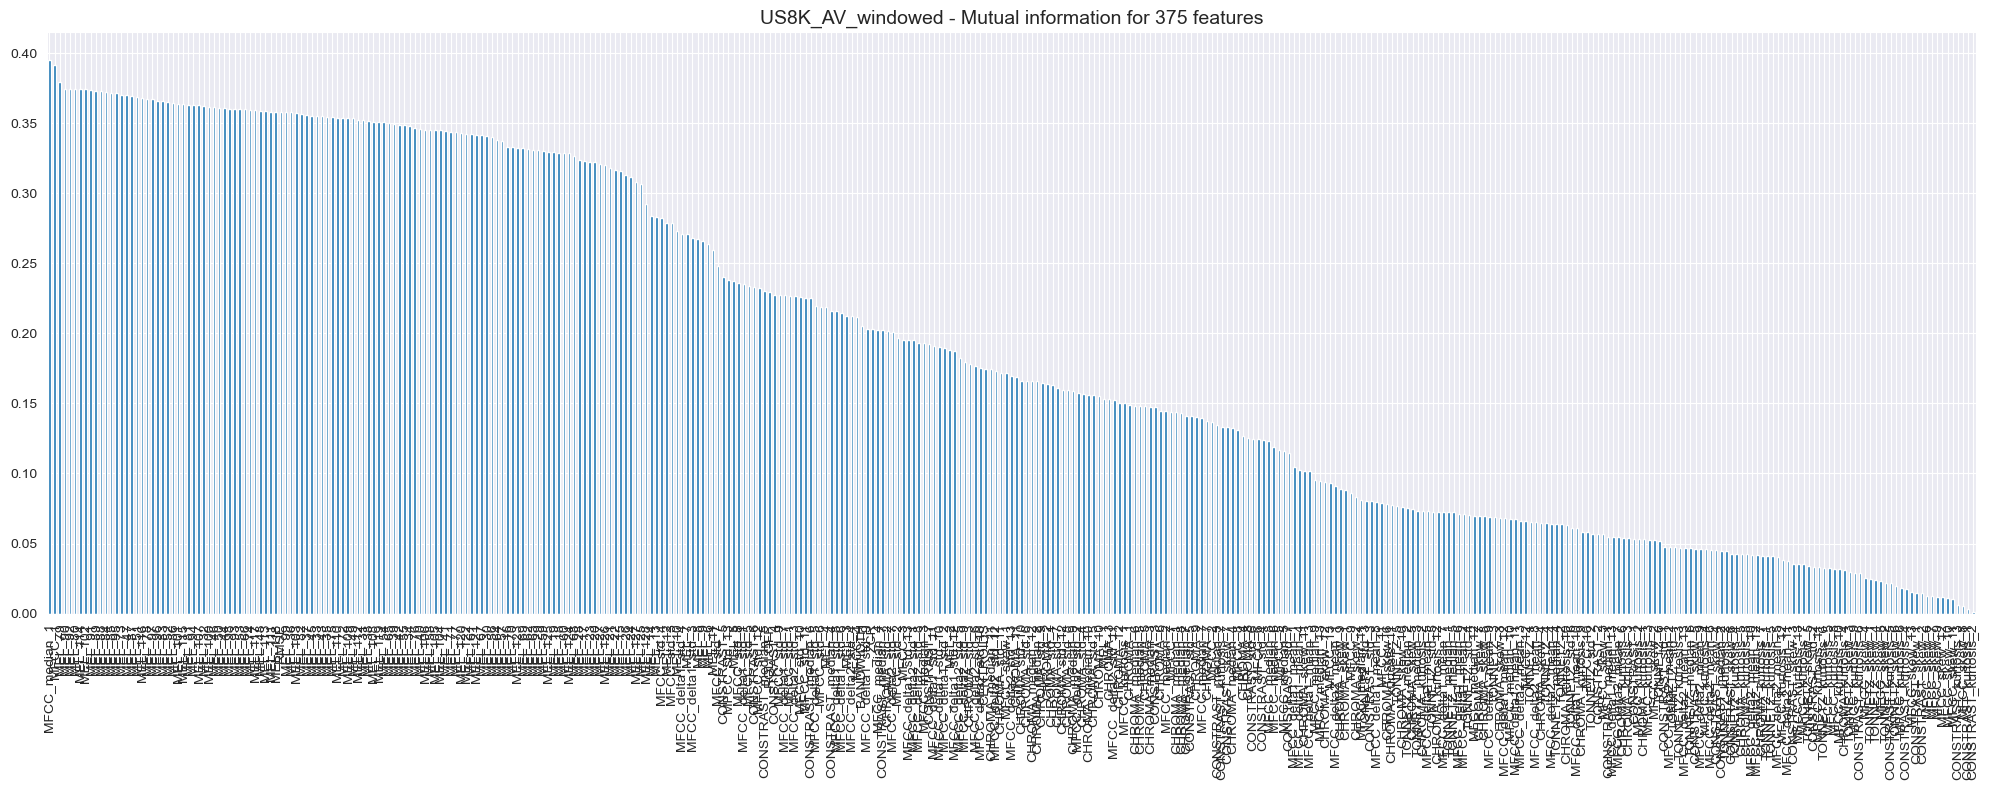

In [67]:
#Plot the sorted features based on their mutual information calculation

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title(nom_dataset + model_surname + ' - Mutual information for ' + str(len(mutual_info)) + ' features', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

### Backup for experiments using *n* relevant features

https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [68]:
chi2_selector = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
f = chi2_selector.get_support(1)
f

array([  0,   1,   2,   3,   4,   7,   8,   9,  11,  12,  13,  14,  16,
        17,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,  30,
        31,  36,  37,  38,  39,  40,  41,  44,  45,  47,  48,  49,  52,
        53,  54,  55,  56,  57,  59,  60,  77,  83,  84,  85,  86,  87,
        88,  89, 103, 105, 106, 107, 108, 109, 110, 114, 119, 131, 132,
       133, 134, 135, 136, 137, 139, 141, 143, 146, 148, 150, 151, 152,
       153, 155, 157, 159, 160, 161, 162, 166, 168, 170, 175, 177, 179,
       184, 186, 188, 193, 195, 197, 202, 204, 206, 211, 213, 215, 220,
       222, 224, 229, 231, 233, 238, 240, 242, 247, 249, 265, 267, 270,
       271, 272, 276, 283, 284, 285, 286, 287, 289, 290, 291, 292, 294,
       295, 296, 297, 299, 300, 301, 302, 305, 306, 307, 309, 310, 311,
       312, 314, 315, 316, 317, 320, 321, 322, 324, 325, 326, 327, 330,
       331, 332, 334, 335, 336, 337, 339, 340, 341, 342, 344, 346, 351,
       356, 361, 366, 371], dtype=int64)

In [69]:
# Stores the indexes for future use
f.tofile(os.path.join(path_models, '_mutual_idx_' + nom_dataset + model_surname + '.csv'), sep=',')

In [70]:
X_new = X[X.columns[f]] # final features
X_new

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_3,MEL_4,MEL_5,MEL_7,MEL_8,...,CHROMA_12,CHROMA_std_12,CHROMA_median_12,CHROMA_kurtosis_12,TONNETZ_std_1,TONNETZ_std_2,TONNETZ_std_3,TONNETZ_std_4,TONNETZ_std_5,TONNETZ_std_6
0,0.117183,0.129483,2069.471399,1734.789901,2861.958452,0.000416,0.000709,0.000580,0.005237,0.003612,...,0.237895,0.149325,0.230933,0.234350,0.063006,0.054696,0.081938,0.121727,0.036064,0.025644
1,0.111724,0.131570,2098.418718,1743.608984,2885.449219,0.000322,0.000599,0.000533,0.005017,0.003528,...,0.256885,0.140828,0.243326,0.134768,0.058376,0.061673,0.087699,0.105361,0.026742,0.026433
2,0.124646,0.131459,2096.616414,1747.412264,2877.618963,0.000453,0.000821,0.000707,0.006273,0.004380,...,0.410597,0.231109,0.387785,0.102878,0.058738,0.049498,0.077355,0.112755,0.029269,0.023640
3,0.110741,0.131658,2093.378630,1736.615179,2873.214444,0.000282,0.000549,0.000491,0.004979,0.003453,...,0.256509,0.146436,0.245916,0.051214,0.048250,0.058753,0.103516,0.105685,0.026361,0.024617
4,0.125728,0.131836,2105.951159,1750.491381,2885.693914,0.001241,0.001559,0.001575,0.006168,0.004680,...,0.241773,0.121148,0.232046,0.220098,0.056431,0.059185,0.091348,0.108055,0.028995,0.024934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34351,0.002225,0.028387,920.881858,1319.656082,2078.932884,0.009807,0.011415,0.013926,0.001700,0.001353,...,0.885502,0.143359,0.950382,0.605420,0.023805,0.012999,0.037477,0.035353,0.011031,0.013994
34352,0.002441,0.028187,882.948049,1265.997091,1975.426691,0.013771,0.012107,0.012164,0.001700,0.001298,...,0.825168,0.191484,0.883150,-0.299986,0.049562,0.022007,0.049692,0.030564,0.011518,0.010918
34353,0.002433,0.029918,888.433237,1238.984897,1956.585138,0.009807,0.015304,0.015679,0.001771,0.001544,...,0.756162,0.216919,0.805324,-0.847685,0.032468,0.052397,0.028613,0.031899,0.025471,0.016168
34354,0.002244,0.032737,898.209632,1196.113306,1924.040638,0.009276,0.011655,0.012598,0.002129,0.001903,...,0.737798,0.221979,0.740034,-1.090412,0.028630,0.027371,0.026349,0.053458,0.018577,0.017644


In [71]:
def get_mutual_info (X: pd.DataFrame, X_norm: list, y: list):
    
    mutual_info = mutual_info_classif(X_norm, y)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X.columns
    mutual_info.sort_values(ascending=False)
    
    threshold = np.mean(mutual_info.sort_values(ascending=False))
    print(f' Threshold: {threshold}')
    
    count_mutual = sum(1 for element in mutual_info if element > threshold)
    print(f' Count mutual: {count_mutual}')
    
    chi2_selector = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
    f = chi2_selector.get_support(1)
    
    X_mutual = X[X.columns[f]] # final features

    return X_mutual

In [72]:
X_test_mutual = get_mutual_info(X, X_norm, y)

 Threshold: 0.19023679155019363
 Count mutual: 173


In [73]:
mutual_info_k_best = mutual_info_classif(X_new, y)
mutual_info_k_best

array([0.35832286, 0.20346777, 0.17464871, 0.20513219, 0.22818405,
       0.2127927 , 0.2189176 , 0.23771052, 0.27125635, 0.26766526,
       0.26564445, 0.2731176 , 0.27881548, 0.28306878, 0.28402384,
       0.31570638, 0.33311368, 0.32336201, 0.32891207, 0.32914779,
       0.31864857, 0.31664319, 0.32238007, 0.31162858, 0.30701391,
       0.3133095 , 0.32075047, 0.36247932, 0.35530722, 0.34827888,
       0.3544925 , 0.35808552, 0.35551497, 0.34579919, 0.34470447,
       0.35530391, 0.36064261, 0.35561666, 0.3590936 , 0.3537266 ,
       0.36132204, 0.36848406, 0.36502584, 0.36037377, 0.3488854 ,
       0.34033392, 0.37056064, 0.37921905, 0.37523259, 0.36322461,
       0.3567349 , 0.36593064, 0.37256957, 0.37193525, 0.35895761,
       0.36424023, 0.37409353, 0.35743598, 0.34450788, 0.34627858,
       0.34503635, 0.3536793 , 0.36336793, 0.3083021 , 0.29193115,
       0.39174644, 0.22699239, 0.39523291, 0.17155347, 0.15017725,
       0.23559824, 0.19503259, 0.19679572, 0.05324275, 0.18973

In [74]:
mutual_info_k_best       = pd.Series(mutual_info_k_best)
mutual_info_k_best.index = X_new.columns
mutual_info_k_best.sort_values(ascending=False)

MFCC_median_1        0.395233
MFCC_1               0.391746
MEL_79               0.379219
MEL_80               0.375233
MEL_102              0.374094
                       ...   
CHROMA_kurtosis_1    0.052835
MFCC_kurtosis_3      0.052532
TONNETZ_std_1        0.047305
CHROMA_kurtosis_5    0.042322
CHROMA_kurtosis_8    0.042195
Length: 173, dtype: float64

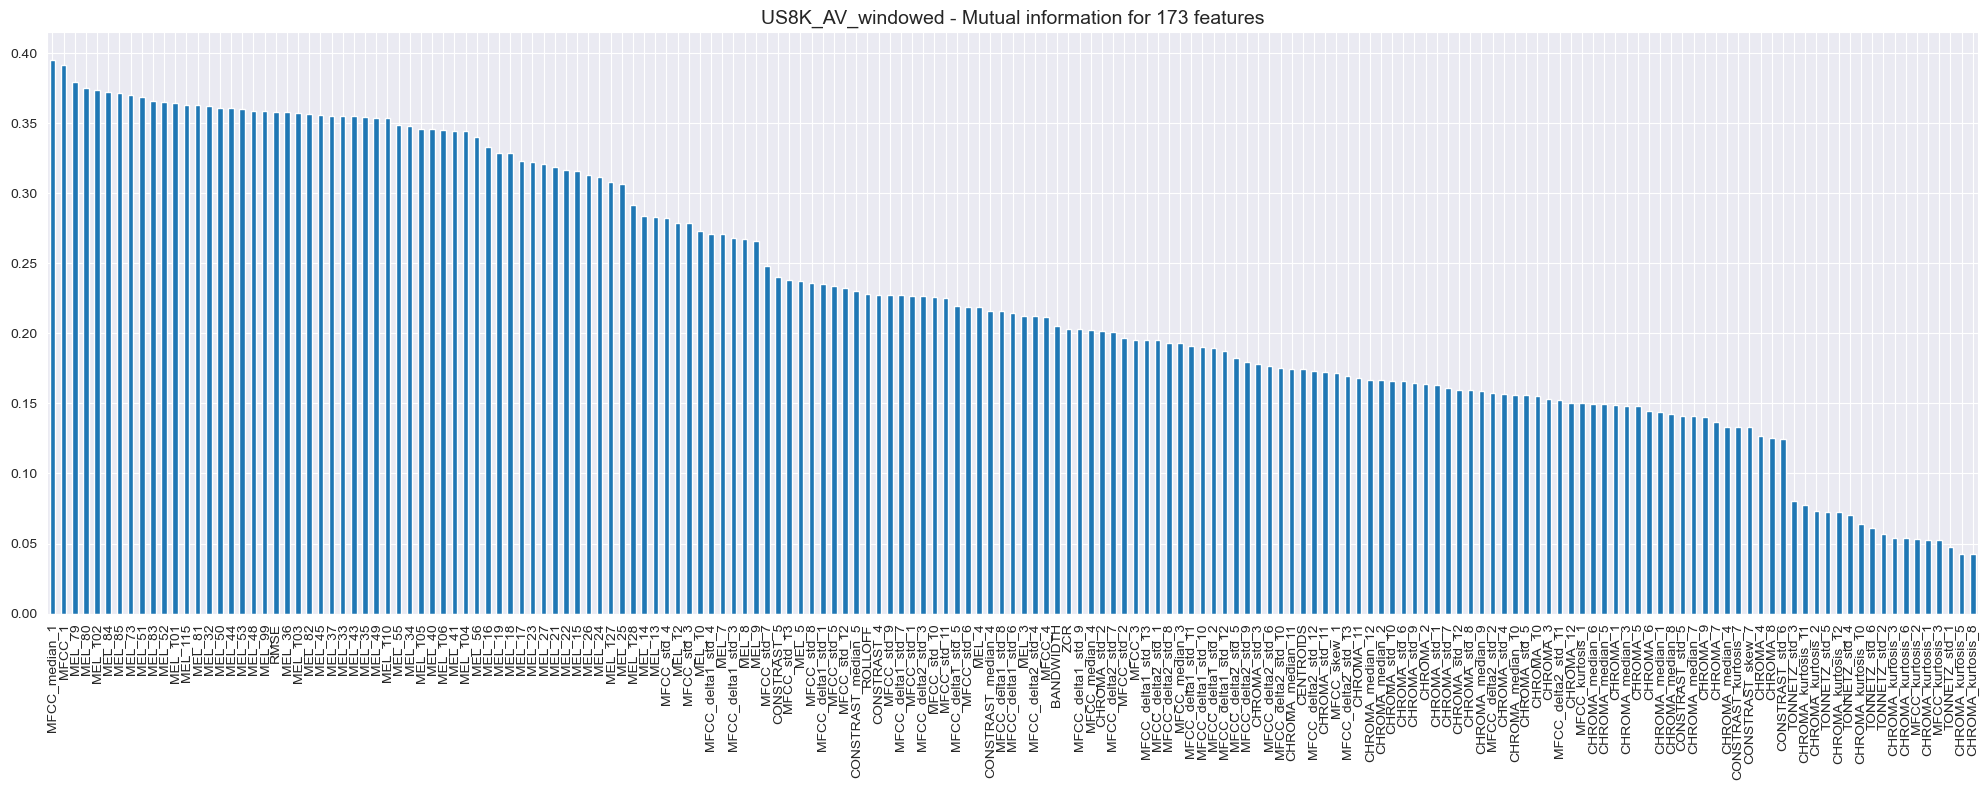

In [75]:
#Plot the sorted features based on their mutual information calculation

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

mutual_info_k_best.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title(nom_dataset + model_surname + ' - Mutual information for ' + str(len(mutual_info_k_best)) + ' features', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

### Remark: by selection the features, re-nornamalize the dataframe

In [76]:
X_new.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_3,MEL_4,MEL_5,MEL_7,MEL_8,...,CHROMA_12,CHROMA_std_12,CHROMA_median_12,CHROMA_kurtosis_12,TONNETZ_std_1,TONNETZ_std_2,TONNETZ_std_3,TONNETZ_std_4,TONNETZ_std_5,TONNETZ_std_6
count,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,...,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000,31010.000000
mean,0.055155,0.105264,1931.242740,1984.335363,3672.744356,6.589169,3.758958,3.513755,3.438620,3.060989,...,0.459357,0.211125,0.428950,0.500744,0.052843,0.052496,0.064578,0.064104,0.027905,0.027652
std,0.064558,0.074818,873.523677,572.049167,1837.033494,34.513440,18.577380,22.277362,22.275866,16.064541,...,0.218049,0.083145,0.254790,3.300799,0.040851,0.040915,0.053031,0.051748,0.021904,0.021531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.996833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.011750,0.058244,1336.078699,1561.221550,2326.136502,0.012139,0.013149,0.013245,0.009235,0.008714,...,0.295148,0.161947,0.222627,-0.965647,0.030655,0.030937,0.035407,0.035258,0.016178,0.016080
50%,0.033189,0.089489,1768.231181,1920.382393,3293.601296,0.156665,0.135417,0.138207,0.098160,0.096235,...,0.464419,0.213979,0.423276,-0.476310,0.041665,0.042122,0.049585,0.049403,0.022016,0.021934
75%,0.075698,0.125372,2294.317438,2337.285111,4537.327298,1.665457,1.273942,1.155583,0.785021,0.797217,...,0.621210,0.267193,0.617758,0.569735,0.060546,0.059134,0.075394,0.075003,0.032045,0.031774
max,0.701893,0.640292,6674.189171,4340.169312,10066.772461,794.016357,664.676392,903.681213,704.793152,443.643433,...,1.000000,0.496361,1.000000,39.023525,0.537298,0.503249,0.621885,0.596607,0.276190,0.257286


### Plotting the Pearson's correlation matrix

In [77]:
corr_matrix = X.corr(method='pearson')
print(corr_matrix)

                        RMSE       ZCR  CENTROIDS  BANDWIDTH   ROLLOFF     MEL_1     MEL_2     MEL_3     MEL_4     MEL_5  ...  TONNETZ_5  TONNETZ_std_5  TONNETZ_median_5  TONNETZ_skew_5  TONNETZ_kurtosis_5  TONNETZ_6  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
RMSE                1.000000  0.108153   0.044896  -0.138867 -0.025649  0.243712  0.271198  0.323435  0.331760  0.339183  ...  -0.113162       0.150736         -0.109181        0.051105            0.150703  -0.019868       0.152795         -0.030995        0.041912            0.095834
ZCR                 0.108153  1.000000   0.856301   0.403918  0.682437 -0.106837 -0.090046 -0.109699 -0.094125 -0.055774  ...  -0.072367      -0.021625         -0.069822        0.005861            0.054476  -0.003148      -0.024860         -0.002890        0.015890            0.076267
CENTROIDS           0.044896  0.856301   1.000000   0.754176  0.938205 -0.077835 -0.059081 -0.090382 -0.067185 -0.036818  ...  -0.036552      

In [78]:
opc = 0
while str(opc) not in '12':
    print()
    print("1-) Print Pearson\'s correlation heatmap.")
    print("2-) Skip printing.")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0
    
    if opc == 1:
        picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

        plt.figure(figsize=(40, 40))
        plt.title(f'{nom_dataset} - Pearson\'s correlation heatmap', fontsize = 16)
        a = sns.heatmap(corr_matrix, 
                        square=True, 
                        annot=True, 
                        fmt='.1f', 
                        linecolor='black', 
                        cbar_kws={"shrink": .80},
                        annot_kws={"fontsize":6})
        a.set_xticklabels(a.get_xticklabels(), fontsize=7)
        a.set_yticklabels(a.get_yticklabels(), fontsize=7) 
        plt.tight_layout()
        plt.savefig(os.path.join(path_pic, picture_name))
        plt.show()
    
    if opc == 2:
        pass


1-) Print Pearson's correlation heatmap.
2-) Skip printing.

Select the dataset: 2


In [79]:
# Método para visualizar a divisão do teste / treino por meio de K Fold e Stratified K Fold

def visualizar_Kfold(dataset, cv, X, y, n_splits):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
    
    sns.set_style("darkgrid")
    
    label_encoder = preprocessing.LabelEncoder()
    y_enc = label_encoder.fit_transform(y)
    y_enc = np.sort(y_enc)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Cria a visualização do treino / test para cada divisão do CV
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y_enc)):
        
        # Preenche os índices com os valores do treino / teste
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualiza os resultados
        ax.scatter(range(len(indices)),
                   [ii + 0.5] * len(indices),
                   c=indices,
                   marker="_",
                   lw=25,
                   cmap=cmap_cv,
                   vmin=-0.2,
                   vmax=1.2)

    # Imprime a linha das classes no final
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y_enc, marker="_", lw=40, cmap=cmap_data)


    # Formatação
    yticklabels = list(range(n_splits)) + ["Classes"]
    ax.set(yticks=np.arange(n_splits + 1) + 0.5,
           yticklabels=yticklabels,
           ylim=[n_splits + 1.0, 0.0],
           xlim=[0, len(y_enc)])
    
    ax.set_xlabel('Samples', fontsize=12)
    ax.set_ylabel('CV iterations', fontsize=12)
    ax.set_title("{}".format(type(cv).__name__) + " " + dataset, fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(0.8)), 
               Patch(color=cmap_cv(0.02))],
              ["Validation set", "Training set"],
              loc=(1.02, 0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

StratifiedShuffleSplit(n_splits=10, random_state=100, test_size=0.1,
            train_size=None)
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
KFold(n_splits=10, random_state=None, shuffle=False)



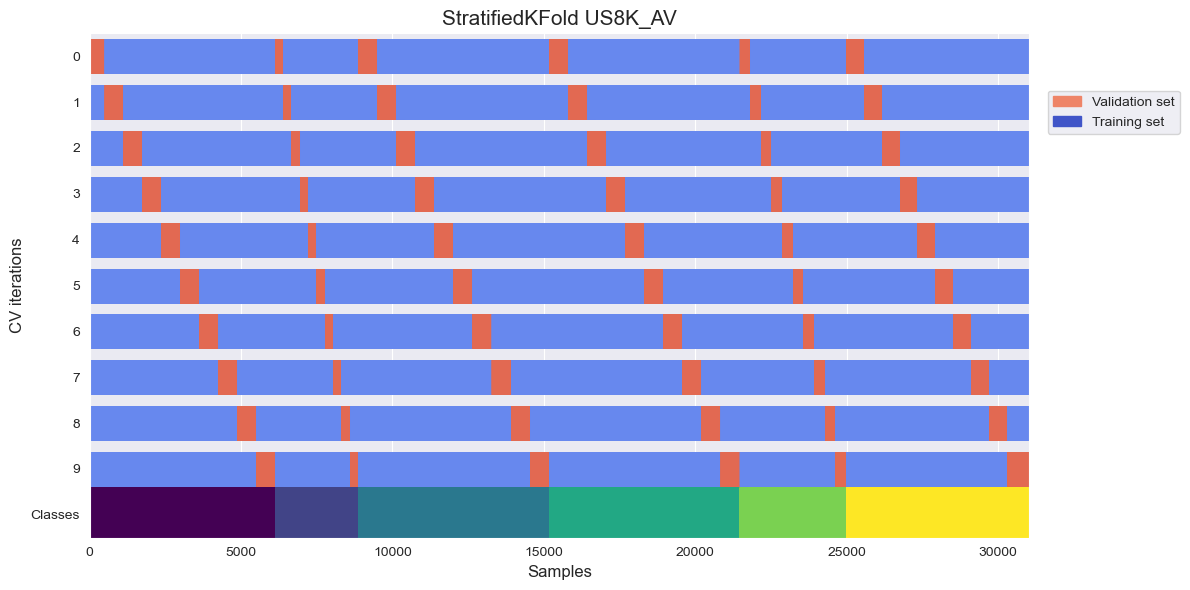

In [80]:
# Visualiza a divisão do treino / teste por meio do Stratified K Fold

print(sss)
print(skf)
print(kfd)
print()

visualizar_Kfold(nom_dataset, skf, X_norm, y, N_SPLITS)

## ML Modeling

In [81]:
del DB_from_pkl_VAL, DB_from_pkl_TRN

In [82]:
# Separate 1 fold for validation and create a DB for the training / testing

opc = 0
while str(opc) not in '12':
    print()
    print("1-) Normalization")
    print("2-) Standardization")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0


    DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
    DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()
    
    X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
    y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

    X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
    y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

    X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

    X_mean   = X_statistics.values[:, 0]
    X_std    = X_statistics.values[:, 1]
    X_min    = X_statistics.values[:, 2]
    X_max    = X_statistics.values[:, 3]
    
    # Normalization or standardization using values from the training set.
    if opc == 1:
        X_norm     = (X.values - X_min) / (X_max - X_min)
        X_val_norm = (X_val.values - X_min) / (X_max - X_min)
        norm_type  = '_norm'

    if opc == 2:
        X_norm     = (X.values - X_mean) / X_std
        X_val_norm = (X_val.values - X_mean) / X_std
        norm_type  = '_std'
        
    # Separated training and testing for hyperparameter cross-validation (10% testing).
    # Testing was not used in this notebook, but it was in the neural networks. In order to achieve a fair comparisson,
    # the same number of samples for training were considered in both notebooks.

    for idx_trn, idx_tst in sss.split(X_norm, y):
        X_train      = X_norm[idx_trn]
        X_test       = X_norm[idx_tst]
        y_train      = y[idx_trn]
        y_test       = y[idx_tst]
        y_train_OHEV = y_OHEV[idx_trn]
        y_test_OHEV  = y_OHEV[idx_tst]
        
        # Stores the indexes for future use
        idx_trn.tofile(os.path.join(path_models, '_idx_trn_' + nom_dataset + model_surname + '.csv'), sep=',')
        idx_tst.tofile(os.path.join(path_models, '_idx_tst_' + nom_dataset + model_surname + '.csv'), sep=',')


1-) Normalization
2-) Standardization

Select the dataset: 2


In [83]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val_norm......: {np.shape(X_val_norm)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')


Training set

X_train.........: (27909, 375)
y_train.........: (27909,)
y_train_OHEV....: (27909, 6)

Testing set

X_test..........: (3101, 375)
y_test..........: (3101,)
y_test_OHEV.....: (3101, 6)

Validation set

X_val_norm......: (3346, 375)
y_val...........: (3346,)
y_OHEV_val......: (3346, 6)


In [84]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = nom_dataset + model_surname + norm_type + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [85]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.tight_layout()

## Classifiers

- **Gaussian Naive Bayes** (GaussianNB) is a probabilistic machine learning algorithm mainly used for classification tasks based on the Naive Bayes theorem and assumes that features are independent and follow a Gaussian (normal) distribution. GaussianNB is particularly suitable for datasets with continuous or real-valued features. It calculates the probabilities of different classes for a given set of input features and assigns the class with the highest probability as the predicted class. Despite its simplifying assumption of feature independence (which is often not met in practice), GaussianNB performs surprisingly well in various real-world applications, such as text classification and spam email detection, due to its simplicity and efficiency. 
***
- The **Support Vector Classifier** (SVC)  is a supervised machine learning algorithm that is primarily used for classification tasksby finding the optimal hyperplane that best separates different classes in the input data. It does this by identifying support vectors, which are the data points closest to the decision boundary. SVC aims to maximize the margin between these support vectors and the decision boundary, making it robust to outliers and capable of handling non-linear data through the use of kernel functions. The algorithm allows for multi-class classification and can be fine-tuned through various parameters like the choice of kernel, regularization strength (C), and kernel-specific parameters. 
***
- **Logistic Regression** is a supervised machine learning algorithm that's primarily employed for binary classification tasks, though it can be extended to handle multiclass classification as well. Despite its name, it's used for classification, not regression. Logistic Regression models the probability of an instance belonging to a particular class as a logistic function of the input features. It's particularly well-suited for linearly separable data, where it tries to find a linear decision boundary that separates the two classes. Regularization techniques like L1 and L2 can be applied to prevent overfitting, while logistic regression assumes a linear relationship between features and the log-odds of the target variable, it can be effective in many practical scenarios and serves as a fundamental building block for more complex models in machine learning.
***
- The **k-Nearest Neighbors** (KNN) algorithm is a simple supervised machine learning technique used primarily for classification and regression tasks. In KNN, a data point's class or value is determined by the majority class or average of its k-nearest neighbors in the feature space. It operates under the assumption that similar data points tend to have similar class labels or target values. The choice of the "k" parameter determines how many neighboring data points are considered when making predictions; a smaller k value leads to more localized decision boundaries, while a larger k value results in smoother, global boundaries. KNN is a non-parametric algorithm, meaning it doesn't make assumptions about the underlying data distribution but it can be computationally expensive for large datasets and may require proper feature scaling and distance metric selection to perform optimally.
***
- **Random Forest** is an ensemble machine learning algorithm used for both classification and regression tasks. It's based on the concept of decision trees, but it builds multiple trees and combines their predictions to improve accuracy and reduce overfitting. In a Random Forest, a random subset of the training data and a random subset of the features are used to grow each tree. This randomness helps create diverse trees that collectively make more robust predictions. During classification, the algorithm aggregates the votes from individual trees, and for regression, it averages their predictions. Random Forest is known for its high accuracy, ability to handle large datasets with many features, and resistance to overfitting. 

In [86]:
# Plot the learning curve for the classifier

def plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std, classifier):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    plt.figsize=(30, 30)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(nom_dataset + model_surname + norm_type + ' - Learning curve for ' + classifier)
    plt.xlabel('Training data size')
    plt.ylabel('Model accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [87]:
NB_c = GaussianNB()
NB_c

GaussianNB()

In [88]:
train_sizes, train_scores, test_scores = learning_curve(estimator = NB_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 2232  4465  6698  8930 11163 13396 15628 17861 20094 22327]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    9.0s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   10.6s remaining:   48.8s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   11.8s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   13.3s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:   14.9s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   16.6s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   17.8s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   19.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.2s finished


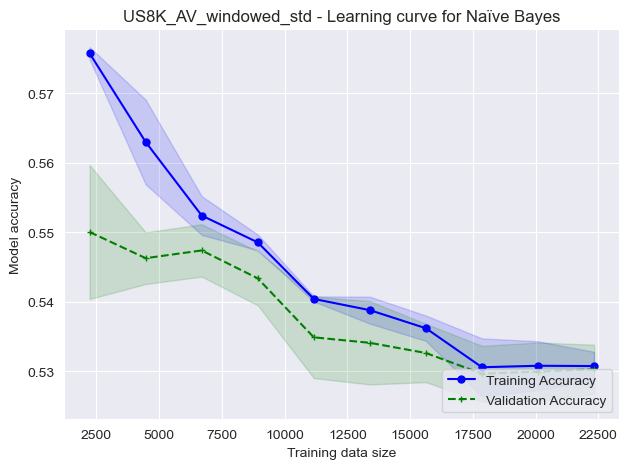

[ 2232  4465  6698  8930 11163 13396 15628 17861 20094 22327] samples were used to train the model

The average train accuracy is....: 54.47 % (+/-0.25 %)
The average test accuracy is.....: 53.78 % (+/-0.49 %)


In [89]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Naïve Bayes')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [90]:
NB_c.fit(X_train, y_train)

GaussianNB()

In [91]:
NB_c_predict = NB_c.predict(X_val_norm)

In [92]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_GaussianNB" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(NB_c, file)

In [93]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    NB_c_saved = pickle.load(file)

In [94]:
score_NB_c_saved = NB_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_NB_c_saved))
NB_c_saved_predict = NB_c_saved.predict(X_val_norm)

Test score (R2): 54.00 %


In [95]:
t_srt = time.process_time_ns()

NB_c_saved_predict_val = NB_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 78,1250 ms


In [96]:
NBC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             NB_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(NBC_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.79      0.33      0.47       756
        car_horn       0.80      0.58      0.68       252
children_playing       0.43      0.80      0.56       700
        dog_bark       0.64      0.25      0.36       700
         silence       0.46      0.96      0.62       336
           siren       0.60      0.58      0.59       602

        accuracy                           0.54      3346
       macro avg       0.62      0.58      0.55      3346
    weighted avg       0.62      0.54      0.52      3346



In [97]:
NBC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             NB_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)

NBC_c_saved_val_class_report_acc = NBC_c_saved_val_class_report['accuracy']
print(NBC_c_saved_val_class_report_acc)

0.5400478182904961


In [98]:
np.array_equal(NB_c_predict, NB_c_saved_predict)

True

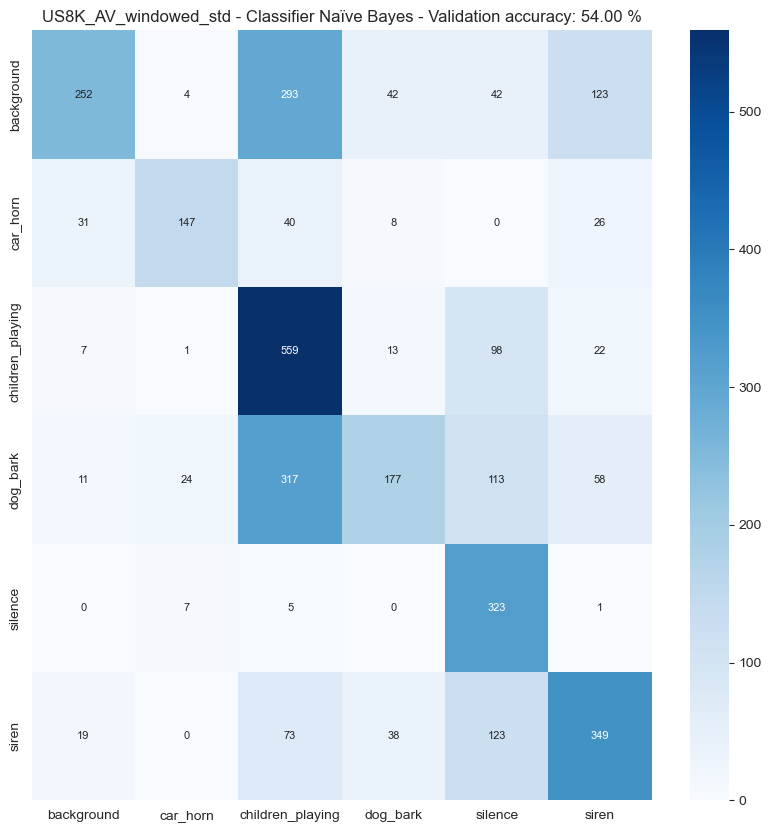

In [99]:
simple_conf_matrix(y_val, 
                   NB_c_saved_predict_val, 
                   nom_classes,
                   'Naïve Bayes',
                   NBC_c_saved_val_class_report_acc)

In [100]:
def get_random_sample(array1, array2):
    # Check if both arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Select a random index
    random_index = random.randint(0, len(array1) - 1)
    print(random_index)

    # Get the sample from the first array and the associated element from the second array
    sample = array1[random_index]
    associated_element = array2[random_index]

    # Return the result as a tuple
    return (sample, associated_element, random_index)

In [101]:
random_sample = get_random_sample(y_val, X_val_norm)

3280


In [102]:
def plot_pred_sample(model, data_label, data, nom_classes):
    
    random_sample = get_random_sample(data_label, data)
    
    print(random_sample[0])
    predict_sample = model.predict([random_sample[1]])[0]

    predict_sample_proba = model.predict_proba([random_sample[1]])
    print(predict_sample)
    
    if random_sample[0] == predict_sample:
        predict_col = 'g'
    else:
        predict_col = 'r'

    # Plotting
    plt.figure(figsize = (16,6))
    plt.bar(nom_classes, predict_sample_proba[0], color = predict_col, alpha = 0.5)
    plt.xlabel('Classes')
    plt.xticks(rotation=90)
    plt.ylabel('Probabilities')
    plt.title(f'Prediction for sample: {random_sample[0]}', fontsize = 14)
    plt.show()
    return random_sample[2]

222
children_playing
children_playing


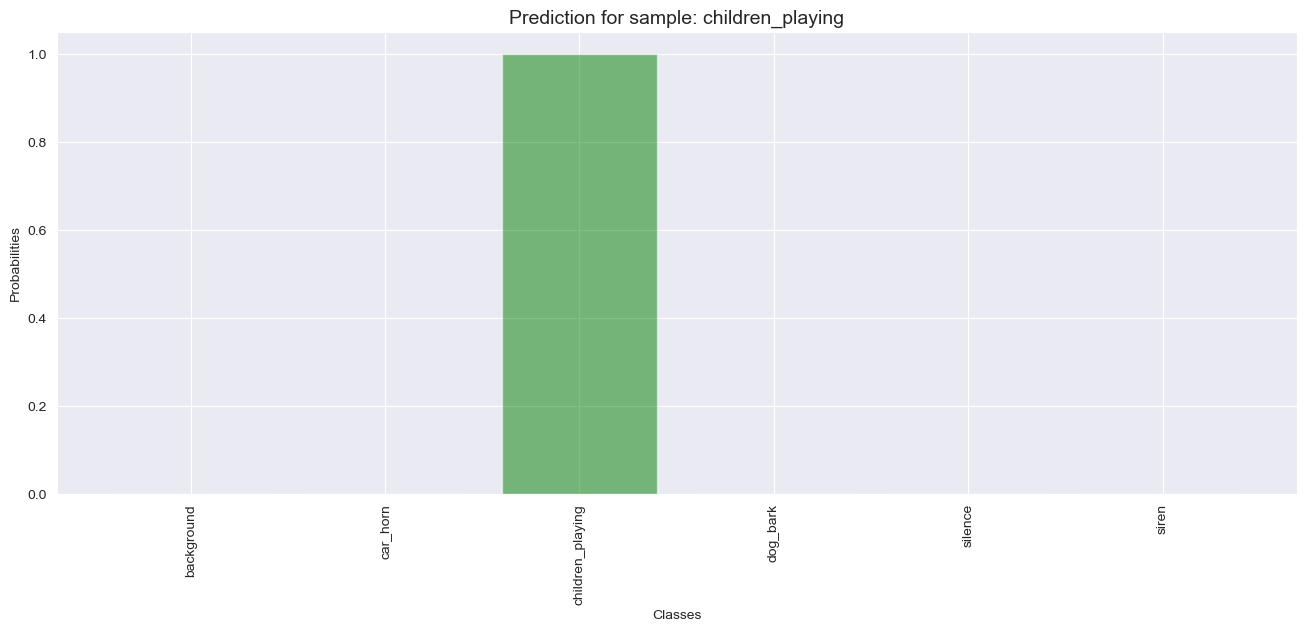

In [103]:
random_index = plot_pred_sample(NB_c_saved, y_val, X_val_norm, nom_classes)

In [104]:
print(y_val[random_index])
print(NB_c_saved.predict([X_val_norm[random_index]])[0])

children_playing
children_playing


In [105]:
# Testing hyperparameters for SVC classifier - After several test, the hyperparameters were set

#SVC_hp = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
#          'degree': [9, 15, 20],
#          'C':[0.010, 0.030, 0.1, 0.2, 0.5], 
#          'probability': [True, False],
#          'random_state': [SEED]}

#grid_SVC = GridSearchCV(SVC(), SVC_hp, refit = True, verbose=3)

#grid_SVC.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_SVC.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_SVC.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_SVC.best_params_)

In [106]:
#grid_SVC.best_params_

In [107]:
# degree = degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.

SVC_c = SVC(kernel       = 'linear',
            degree       = 9,  
            C            = 0.5, 
            probability  = True, 
            random_state = SEED,
            verbose      = True)
SVC_c

SVC(C=0.5, degree=9, kernel='linear', probability=True, random_state=1000,
    verbose=True)

In [108]:
train_sizes, train_scores, test_scores = learning_curve(estimator = SVC_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.2, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 4465  6450  8434 10419 12403 14388 16373 18357 20342 22327]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  2.5min remaining: 39.5min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  9.5min remaining: 43.4min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 16.8min remaining: 39.3min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 25.3min remaining: 34.9min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 31.6min remaining: 26.9min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 38.2min remaining: 19.7min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 47.2min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 54.3min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 59.0min finished


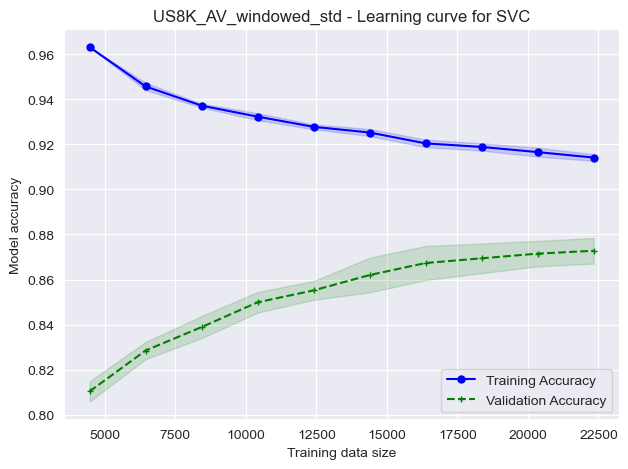

[ 4465  6450  8434 10419 12403 14388 16373 18357 20342 22327] samples were used to train the model

The average train accuracy is....: 93.01 % (+/-0.13 %)
The average test accuracy is.....: 85.26 % (+/-0.55 %)


In [109]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'SVC')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [110]:
SVC_c.fit(X_train, y_train)

[LibSVM]

SVC(C=0.5, degree=9, kernel='linear', probability=True, random_state=1000,
    verbose=True)

In [111]:
SVC_c_predict = SVC_c.predict(X_val_norm)

In [112]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_SVC" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(SVC_c, file)

In [113]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    SVC_c_saved = pickle.load(file)

In [114]:
score_SVC_c_saved = SVC_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_SVC_c_saved))
SVC_c_saved_predict = SVC_c_saved.predict(X_val_norm)

Test score (R2): 74.60 %


In [115]:
t_srt = time.process_time_ns()

SVC_c_saved_predict_val = SVC_c_saved.predict(X_val_norm)
2
t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 5375,0000 ms


In [116]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(SVC_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.78      0.77      0.77       756
        car_horn       0.80      0.93      0.86       252
children_playing       0.67      0.79      0.73       700
        dog_bark       0.74      0.78      0.76       700
         silence       0.69      0.57      0.63       336
           siren       0.83      0.64      0.73       602

        accuracy                           0.75      3346
       macro avg       0.75      0.75      0.75      3346
    weighted avg       0.75      0.75      0.74      3346



In [117]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)
SVC_c_saved_val_class_report_acc = SVC_c_saved_val_class_report['accuracy']
SVC_c_saved_val_class_report_acc

0.7459653317393903

In [118]:
np.array_equal(SVC_c_predict, SVC_c_saved_predict)

True

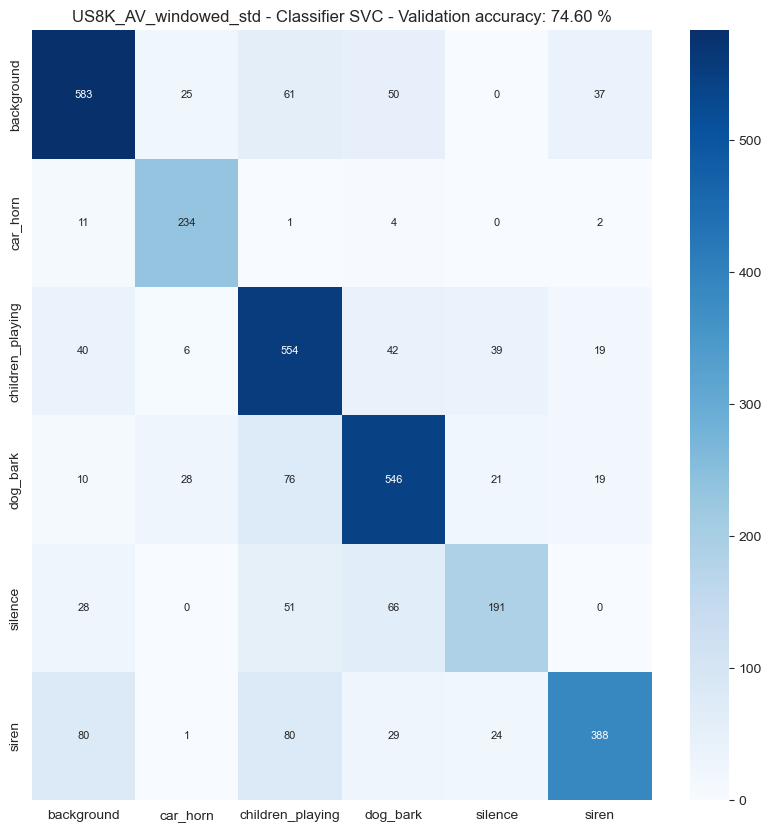

In [119]:
simple_conf_matrix(y_val, 
                   SVC_c_saved_predict_val, 
                   nom_classes,
                   'SVC',
                   SVC_c_saved_val_class_report_acc)

625
children_playing
children_playing


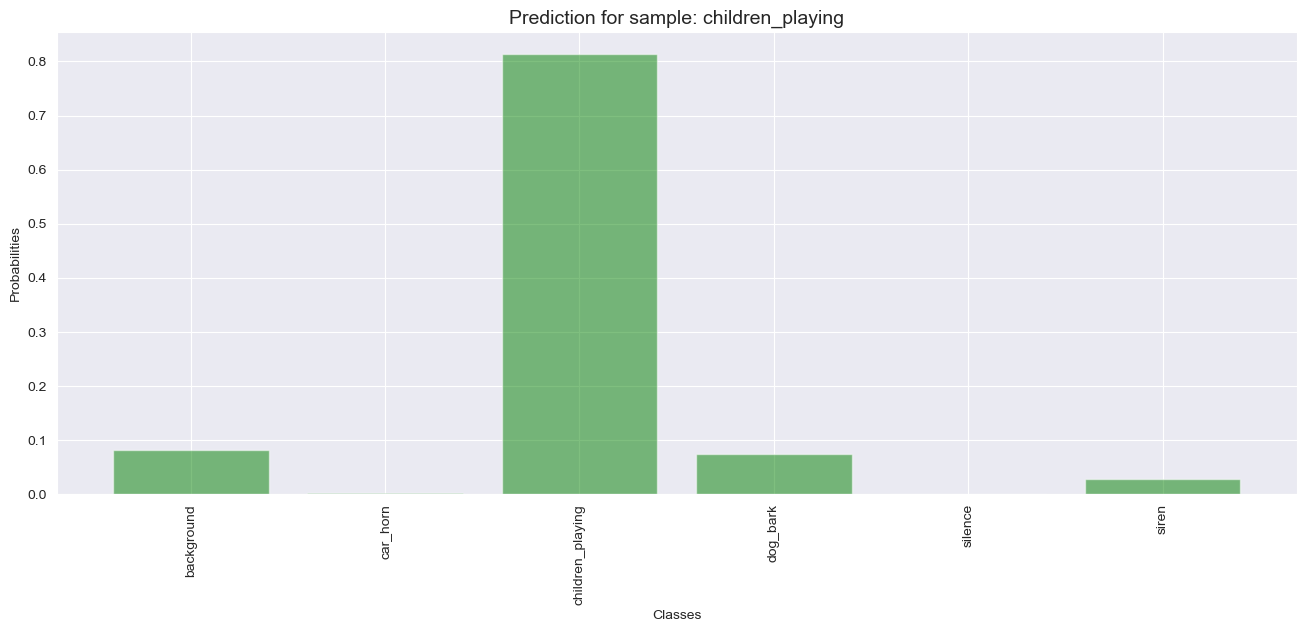

In [120]:
random_index = plot_pred_sample(SVC_c_saved, y_val, X_val_norm, nom_classes)

In [121]:
print(random_index)
print(y_val[random_index])
print(SVC_c_saved.predict([X_val_norm[random_index]])[0])

625
children_playing
children_playing


In [122]:
# Testing hyperparameters for Logistic Regression classifier - After several test, the hyperparameters were set

#LogisticR_hp = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
#                'penalty': ['l1', 'l2', 'elasticnet', None],
#                'max_iter':[100, 150, 200, 500],
#                'C':[0.010, 0.030, 0.1, 0.2, 0.5]}

#grid_LogisticR = GridSearchCV(LogisticRegression(), LogisticR_hp, refit = True, verbose=3)

#grid_LogisticR.fit(X_train, y_train)

#print(" Results from Grid Search in the Logistic Regression classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_LogisticR.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_LogisticR.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_LogisticR.best_params_)

In [123]:
#grid_LogisticR.best_params_

In [124]:
LogisticR_c = LogisticRegression(solver    = 'saga', 
                                 C         = 0.5, 
                                 max_iter  = 500,
                                 verbose   = 10,
                                 n_jobs    = -1)
LogisticR_c

LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga', verbose=10)

In [125]:
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticR_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.2, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 4465  6450  8434 10419 12403 14388 16373 18357 20342 22327]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  1.4min remaining: 22.3min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  3.0min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  4.2min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  6.0min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  7.2min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  8.9min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 10.3min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 12.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.5min finished


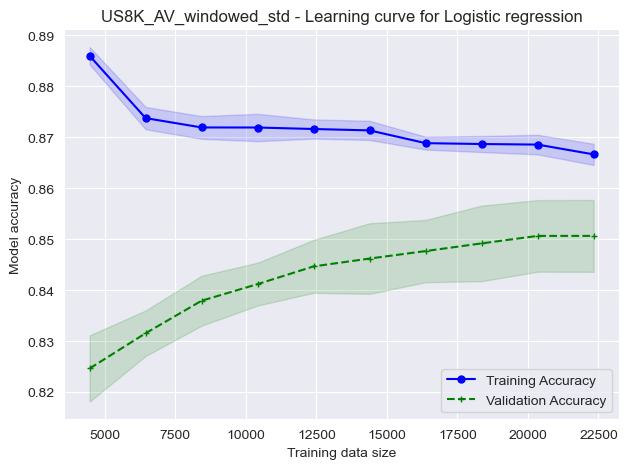

[ 4465  6450  8434 10419 12403 14388 16373 18357 20342 22327] samples were used to train the model

The average train accuracy is....: 87.19 % (+/-0.19 %)
The average test accuracy is.....: 84.24 % (+/-0.60 %)


In [126]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Logistic regression')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [127]:
LogisticR_c.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 174 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.9min finished


LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga', verbose=10)

In [128]:
LogisticR_c_predict = LogisticR_c.predict(X_val_norm)

In [129]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_LogisticR" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(LogisticR_c, file)

In [130]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    LogisticR_c_saved = pickle.load(file)

In [131]:
score_LogisticR_c_saved = LogisticR_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_LogisticR_c_saved))
LogisticR_c_saved_predict = LogisticR_c_saved.predict(X_val_norm)

Test score (R2): 79.38 %


In [132]:
t_srt = time.process_time_ns()

LogisticR_c_saved_predict_val = LogisticR_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 62,5000 ms


In [133]:
LogisticR_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                   LogisticR_c_saved_predict_val, 
                                                                   target_names = nom_classes, 
                                                                   output_dict = False)
print(LogisticR_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.84      0.75      0.79       756
        car_horn       0.81      0.93      0.87       252
children_playing       0.74      0.81      0.77       700
        dog_bark       0.80      0.80      0.80       700
         silence       0.73      0.81      0.77       336
           siren       0.84      0.77      0.80       602

        accuracy                           0.79      3346
       macro avg       0.79      0.81      0.80      3346
    weighted avg       0.80      0.79      0.79      3346



In [134]:
LogisticR_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                   LogisticR_c_saved_predict_val, 
                                                                   target_names = nom_classes, 
                                                                   output_dict = True)
LogisticR_c_saved_val_class_report_acc = LogisticR_c_saved_val_class_report['accuracy']
LogisticR_c_saved_val_class_report_acc

0.793783622235505

In [135]:
np.array_equal(LogisticR_c_predict, LogisticR_c_saved_predict)

True

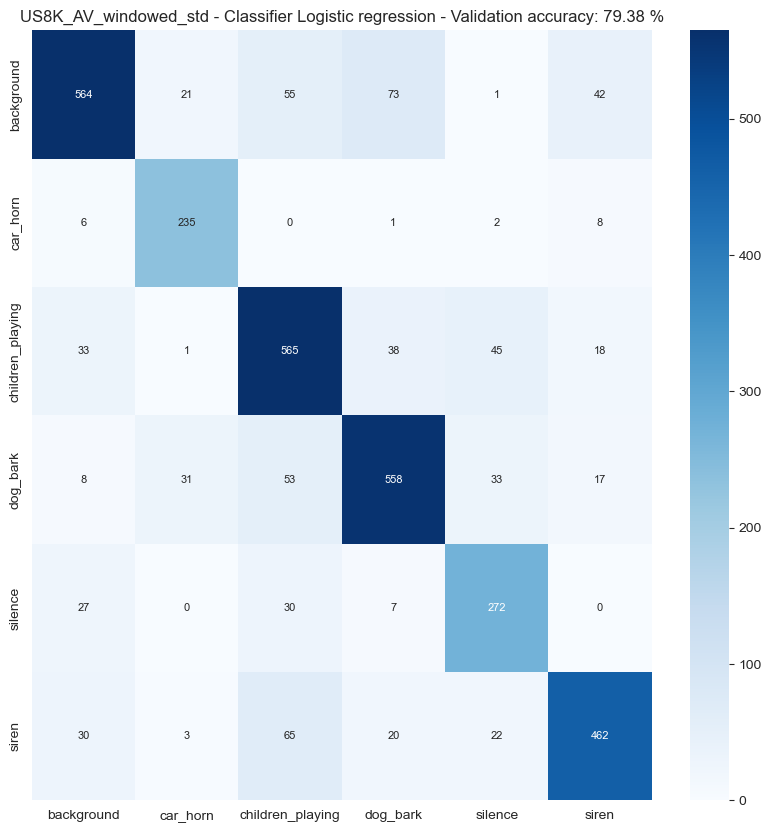

In [136]:
simple_conf_matrix(y_val, 
                   LogisticR_c_saved_predict_val, 
                   nom_classes,
                   'Logistic regression',
                   LogisticR_c_saved_val_class_report_acc)

2593
background
dog_bark


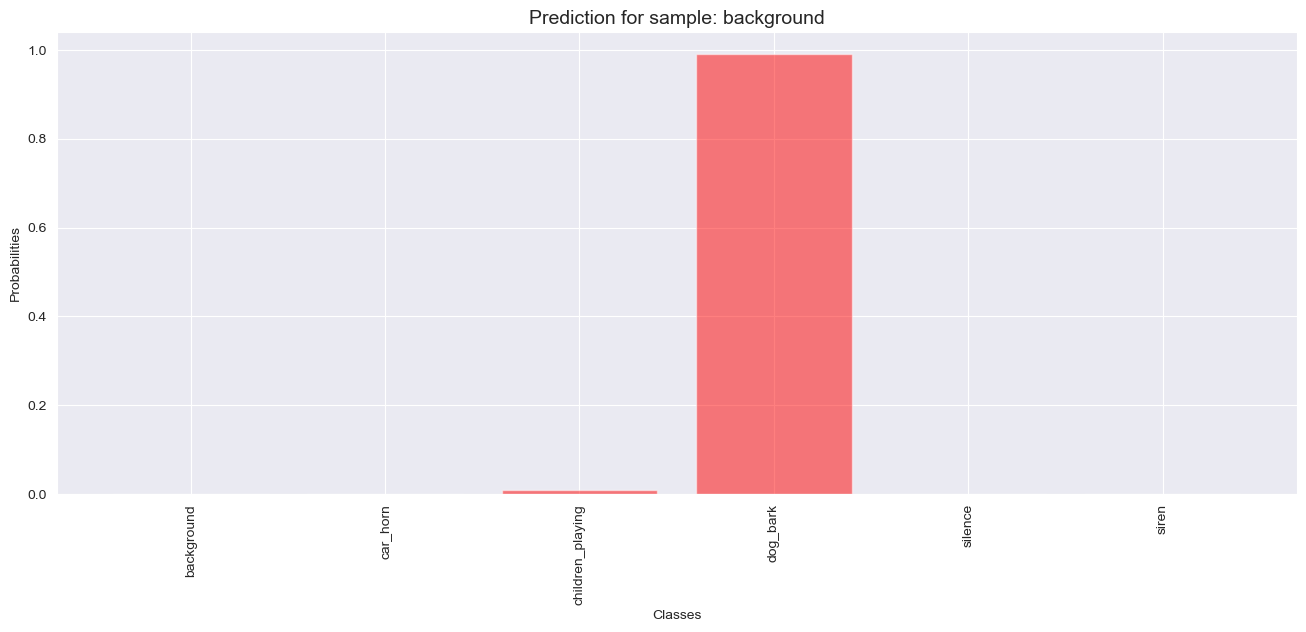

In [137]:
random_index = plot_pred_sample(LogisticR_c_saved, y_val, X_val_norm, nom_classes)

In [138]:
print(y_val[random_index])
print(LogisticR_c_saved.predict([X_val_norm[random_index]])[0])

background
dog_bark


In [139]:
# Testing hyperparameters for KNN classifier - After several test, the hyperparameters were set

#KNN_hp = {'n_neighbors':[3, 5, 8, 12], 
#          'metric': ['mahalanobis', 'euclidean', 'minkowski'],
#          'p':[1, 2], 
#          'leaf_size': [20, 40, 80]}

#grid_KNN = GridSearchCV(KNeighborsClassifier(), KNN_hp, refit = True, verbose=3)

#grid_KNN.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_KNN.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_KNN.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_KNN.best_params_)

In [140]:
#grid_KNN.best_params_

In [141]:
KNN_c = KNeighborsClassifier(n_neighbors = 3,
                             metric      = 'minkowski',
                             p           = 2,
                             leaf_size   = 20,
                             n_jobs      = -1)
KNN_c

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)

In [142]:
train_sizes, train_scores, test_scores = learning_curve(estimator = KNN_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 2232  4465  6698  8930 11163 13396 15628 17861 20094 22327]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    5.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   15.9s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   23.0s remaining:   53.8s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   32.0s remaining:   44.2s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:   40.6s remaining:   34.6s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   47.2s remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   55.0s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  1.1min remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


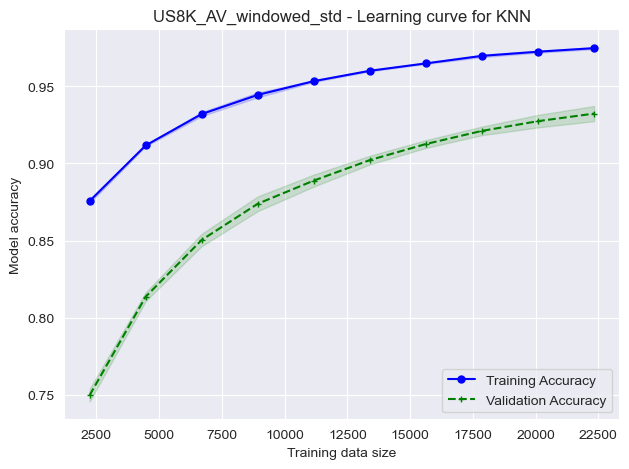

[ 2232  4465  6698  8930 11163 13396 15628 17861 20094 22327] samples were used to train the model

The average train accuracy is....: 94.60 % (+/-0.08 %)
The average test accuracy is.....: 87.72 % (+/-0.37 %)


In [143]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'KNN')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [144]:
KNN_c.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)

In [145]:
KNN_c_predict = KNN_c.predict(X_val_norm)

In [146]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_KNN" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(KNN_c, file)

In [147]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    KNN_c_saved = pickle.load(file)

In [148]:
score_KNN_c_saved = KNN_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_KNN_c_saved))
KNN_c_saved_predict = KNN_c_saved.predict(X_val_norm)

Test score (R2): 73.22 %


In [149]:
t_srt = time.process_time_ns()

KNN_c_saved_predict_val = KNN_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 5171,8750 ms


In [150]:
KNN_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             KNN_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(KNN_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.79      0.63      0.70       756
        car_horn       0.74      0.83      0.78       252
children_playing       0.61      0.81      0.70       700
        dog_bark       0.79      0.64      0.71       700
         silence       0.70      0.91      0.79       336
           siren       0.84      0.74      0.79       602

        accuracy                           0.73      3346
       macro avg       0.75      0.76      0.74      3346
    weighted avg       0.75      0.73      0.73      3346



In [151]:
KNN_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             KNN_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)
KNN_c_saved_val_class_report_acc = KNN_c_saved_val_class_report['accuracy']
KNN_c_saved_val_class_report_acc

0.7322175732217573

In [152]:
np.array_equal(KNN_c_predict, KNN_c_saved_predict)

True

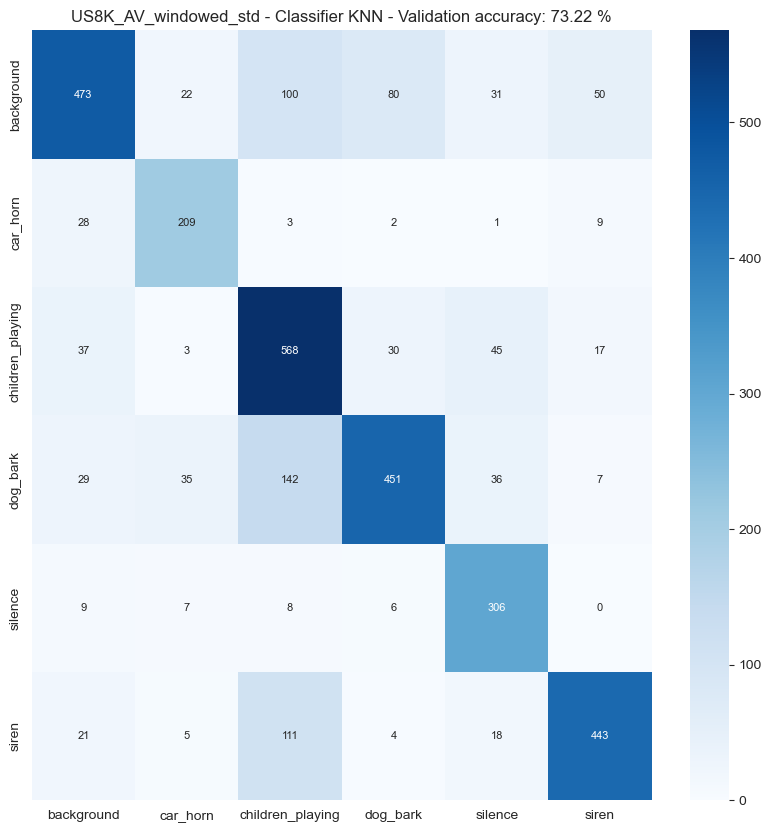

In [153]:
simple_conf_matrix(y_val, 
                   KNN_c_saved_predict_val, 
                   nom_classes,
                   'KNN',
                   KNN_c_saved_val_class_report_acc)

1932
children_playing
children_playing


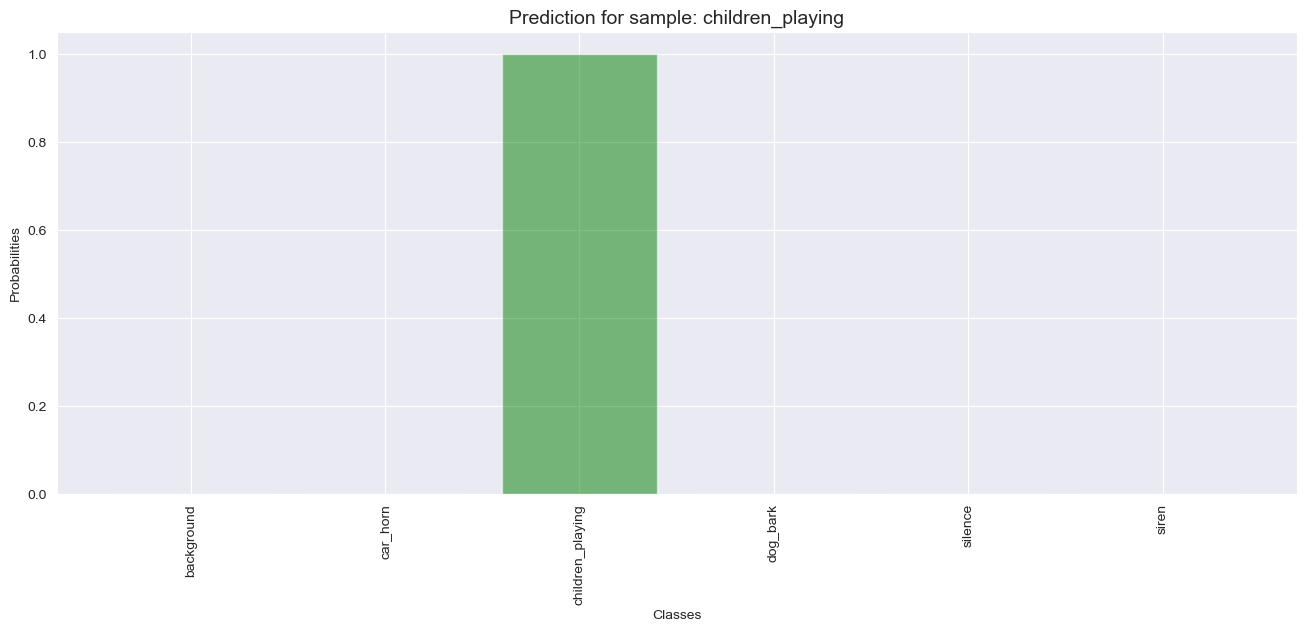

In [154]:
random_index = plot_pred_sample(KNN_c_saved, y_val, X_val_norm, nom_classes)

In [155]:
print(y_val[random_index])
print(KNN_c_saved.predict([X_val_norm[random_index]])[0])

children_playing
children_playing


In [156]:
# Testing hyperparameters for random forest classifier (ensemble method) - After several test, the hyperparameters were set

#forest_hp = {'n_estimators':[10, 25, 50, 100, 200, 500], 
#             'criterion': ['gini', 'entropy', 'log_loss'],
#             'bootstrap':[True, False]}

#grid_forest = GridSearchCV(RandomForestClassifier(), forest_hp, refit = True, verbose=3)

#grid_forest.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_forest.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_forest.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_forest.best_params_)

In [157]:
#grid_forest.best_params_

In [158]:
# Change to verbose = 0 when running the US8K_AV to avoid showing the information during the evaluation flow
forest_c = RandomForestClassifier(criterion    = 'gini',
                                  n_estimators = 500,
                                  bootstrap    = True,
                                  n_jobs       = -1,
                                  verbose      = 0)
forest_c

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [159]:
train_sizes, train_scores, test_scores = learning_curve(estimator = forest_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

[learning_curve] Training set sizes: [ 2232  4465  6698  8930 11163 13396 15628 17861 20094 22327]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  3.6min remaining: 56.5min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  9.7min remaining: 44.1min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 15.5min remaining: 36.1min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 20.6min remaining: 28.5min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 26.3min remaining: 22.4min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 31.0min remaining: 16.0min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 37.5min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 42.5min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 44.9min finished


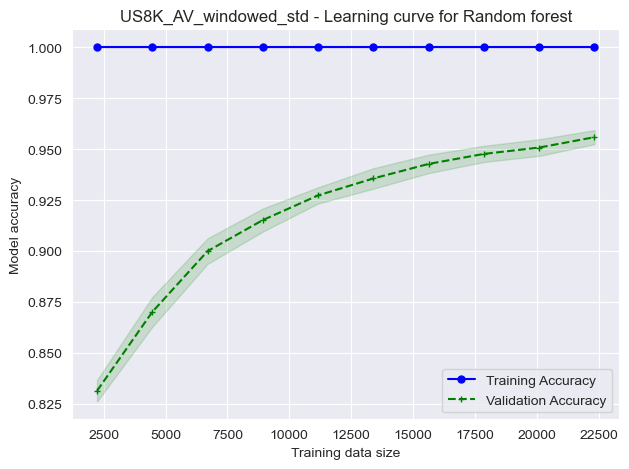

[ 2232  4465  6698  8930 11163 13396 15628 17861 20094 22327] samples were used to train the model

The average train accuracy is....: 100.00 % (+/-0.00 %)
The average test accuracy is.....: 91.76 % (+/-0.50 %)


In [160]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Random forest')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [161]:
forest_c.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [162]:
forest_c_predict = forest_c.predict(X_val_norm)

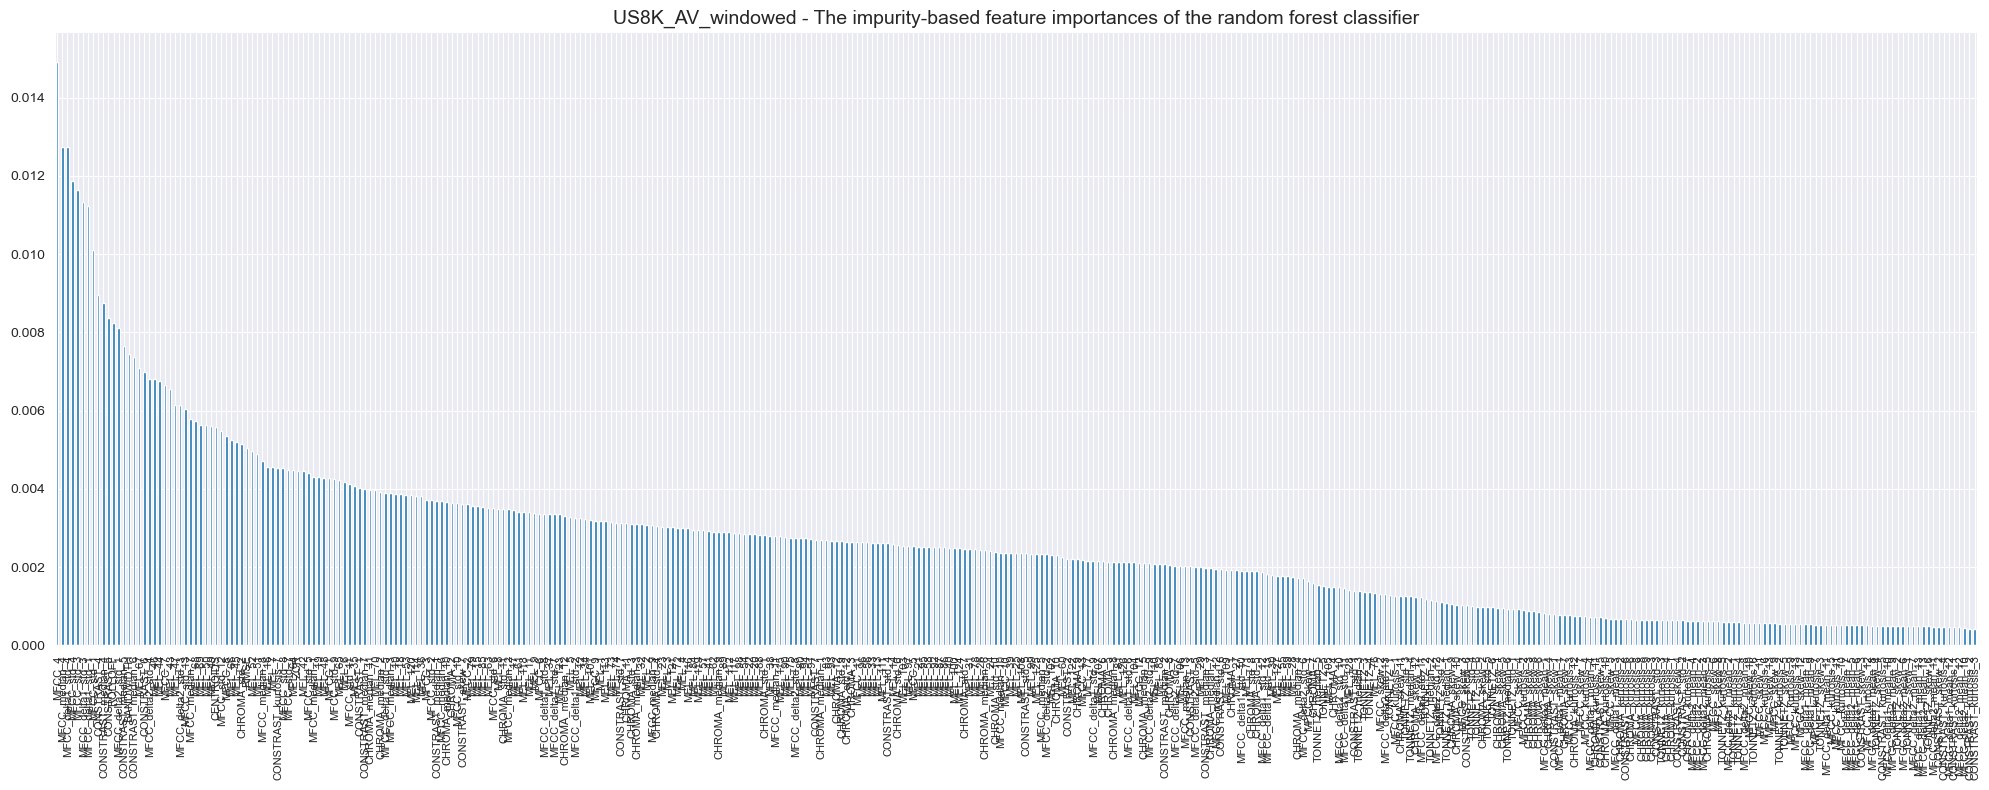

In [163]:
# Plot the feature importances of the random forest classifier

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
plt.figure(num=None, figsize=(20,8), facecolor='w', edgecolor='k')
feat_importances = pd.Series(forest_c.feature_importances_, index= X.columns)
temp_feature     = feat_importances.nlargest(375).reset_index()
rff = feat_importances.nlargest(375).plot(kind='bar')
rff.set_xticklabels(temp_feature['index'], fontsize=8)
plt.title(nom_dataset + model_surname + ' - The impurity-based feature importances of the random forest classifier', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

In [164]:
feat_importances.nlargest(375).sum()

1.0

In [165]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_Forest" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(forest_c, file)

In [166]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    forest_c_saved = pickle.load(file)

In [167]:
score_forest_c_saved = forest_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_forest_c_saved))
forest_c_saved_predict = forest_c_saved.predict(X_val_norm)

Test score (R2): 79.32 %


In [168]:
t_srt = time.process_time_ns()

forest_c_saved_predict_val = forest_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 828,1250 ms


In [169]:
forest_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                forest_c_saved_predict_val, 
                                                                target_names = nom_classes, 
                                                                output_dict = False)
print(forest_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.78      0.76      0.77       756
        car_horn       0.88      0.76      0.82       252
children_playing       0.69      0.85      0.76       700
        dog_bark       0.86      0.78      0.82       700
         silence       0.74      0.85      0.79       336
           siren       0.91      0.76      0.83       602

        accuracy                           0.79      3346
       macro avg       0.81      0.79      0.80      3346
    weighted avg       0.80      0.79      0.79      3346



In [170]:
forest_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                forest_c_saved_predict_val, 
                                                                target_names = nom_classes, 
                                                                output_dict = True)
forest_c_saved_val_class_report_acc = forest_c_saved_val_class_report['accuracy']
forest_c_saved_val_class_report_acc

0.7931858936043037

In [171]:
np.array_equal(forest_c_predict, forest_c_saved_predict)

True

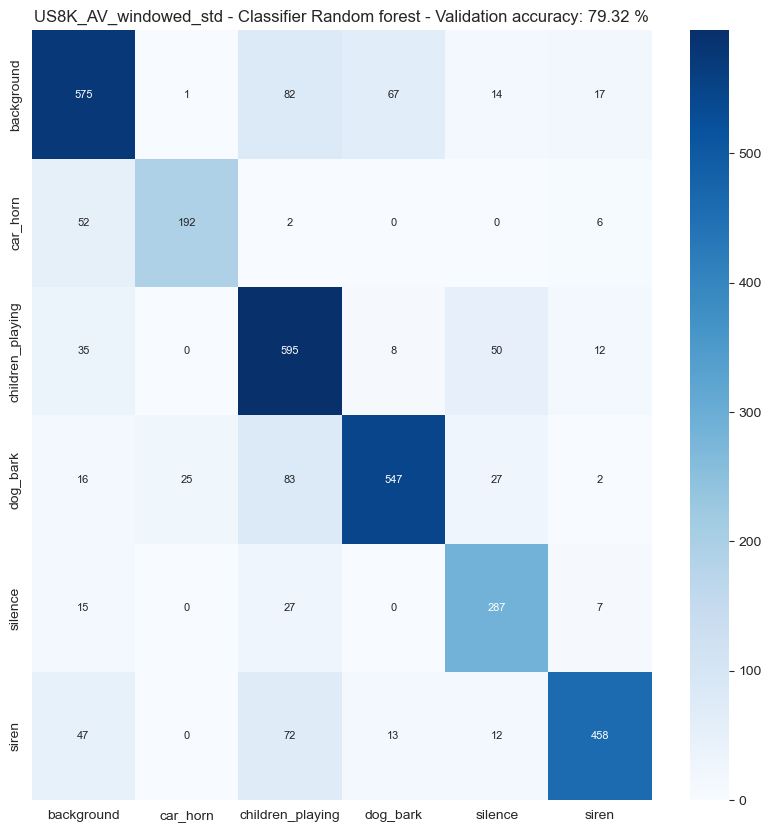

In [172]:
simple_conf_matrix(y_val, 
                   forest_c_saved_predict_val, 
                   nom_classes,
                   'Random forest',
                   forest_c_saved_val_class_report_acc)

1063
siren
siren


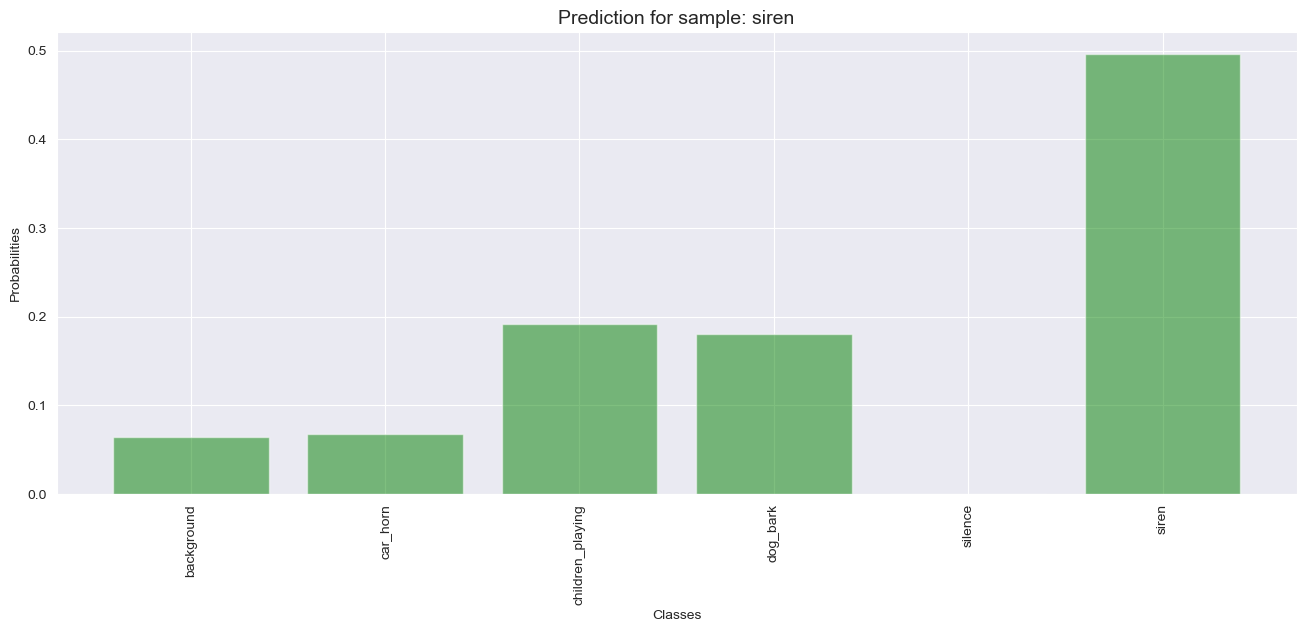

In [173]:
random_index = plot_pred_sample(forest_c_saved, y_val, X_val_norm, nom_classes)

In [174]:
print(y_val[random_index])
print(forest_c_saved.predict([X_val_norm[random_index]])[0])

siren
siren


### Evaluating a voting classifier for the ML algorithms

In [175]:
labels = ['Naïves Bayes', 'SVC', 'Logistic regression', 'KNN']

In [176]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c], labels):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, " Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Naïves Bayes  Accuracy: 53.03 % (+/- 0.35 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.1min remaining: 19.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 13.3min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min finished


SVC  Accuracy: 87.28 % (+/- 0.57 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.3min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.3min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Logistic regression  Accuracy: 85.08 % (+/- 0.71 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


KNN  Accuracy: 93.24 % (+/- 0.49 %)


In [177]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], NB_c),
                                                 (labels[1], SVC_c),
                                                 (labels[2], LogisticR_c),
                                                 (labels[3], KNN_c)],
                                   voting = 'hard',
                                   n_jobs = -1,
                                   verbose = True)

In [178]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], NB_c),
                                                 (labels[1], SVC_c),
                                                 (labels[2], LogisticR_c),
                                                 (labels[3], KNN_c)],
                                   voting = 'soft',
                                   n_jobs = -1,
                                   verbose = True)

In [179]:
# Save the classifier to file in the current working directory

pkl_filename_hard = "Model_voting_hard" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename_hard), 'wb') as file:
    pickle.dump(voting_clf_hard, file)

In [180]:
# Save the classifier to file in the current working directory

pkl_filename_soft = "Model_voting_soft" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename_soft), 'wb') as file:
    pickle.dump(voting_clf_soft, file)

In [181]:
labels_new = ['Naïves Bayes', 'SVC', 'Logistic regression', 'KNN', 'Random forest', 'Voting hard', 'Voting soft']

In [182]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename_hard), 'rb') as file:
    voting_clf_hard_saved = pickle.load(file)

In [183]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename_soft), 'rb') as file:
    voting_clf_soft_saved = pickle.load(file)

In [184]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c, forest_c, voting_clf_hard, voting_clf_soft], labels_new):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, " Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Naïves Bayes  Accuracy: 53.03 % (+/- 0.35 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.8min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.8min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.0min finished


SVC  Accuracy: 87.28 % (+/- 0.57 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


Logistic regression  Accuracy: 85.07 % (+/- 0.69 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


KNN  Accuracy: 93.24 % (+/- 0.49 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.7min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  8.7min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.7min finished


Random forest  Accuracy: 95.61 % (+/- 0.35 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.2min remaining: 19.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 13.3min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min finished


Voting hard  Accuracy: 88.44 % (+/- 0.75 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.5min remaining: 20.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 13.6min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.8min finished


Voting soft  Accuracy: 89.30 % (+/- 0.55 %)


In [185]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c, forest_c, voting_clf_hard_saved, voting_clf_soft_saved], labels_new):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, "Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Naïves Bayes Accuracy: 53.03 % (+/- 0.35 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.4min remaining: 18.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.4min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.7min finished


SVC Accuracy: 87.28 % (+/- 0.57 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


Logistic regression Accuracy: 85.08 % (+/- 0.70 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


KNN Accuracy: 93.24 % (+/- 0.49 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.0min remaining: 13.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  9.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.0min finished


Random forest Accuracy: 95.65 % (+/- 0.34 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.2min remaining: 19.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 13.3min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min finished


Voting hard Accuracy: 88.44 % (+/- 0.76 %)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.6min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.8min finished


Voting soft Accuracy: 89.30 % (+/- 0.55 %)


In [186]:
voting_clf_hard_saved.fit(X_train, y_train)

VotingClassifier(estimators=[('Naïves Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, degree=9, kernel='linear',
                                  probability=True, random_state=1000,
                                  verbose=True)),
                             ('Logistic regression',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga', verbose=10)),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 n_jobs=-1, verbose=True)

In [187]:
t_srt = time.process_time_ns()

votingHard_c_saved_predict_val = voting_clf_hard_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 11906,2500 ms


In [188]:
votingHard_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingHard_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = False)
print(votingHard_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.83      0.78      0.81       756
        car_horn       0.85      0.90      0.87       252
children_playing       0.67      0.85      0.75       700
        dog_bark       0.82      0.71      0.76       700
         silence       0.73      0.84      0.78       336
           siren       0.91      0.74      0.82       602

        accuracy                           0.79      3346
       macro avg       0.80      0.80      0.80      3346
    weighted avg       0.80      0.79      0.79      3346



In [189]:
votingHard_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingHard_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = True)
votingHard_c_saved_val_class_report_acc = votingHard_c_saved_val_class_report['accuracy']
votingHard_c_saved_val_class_report_acc

0.7890017931858936

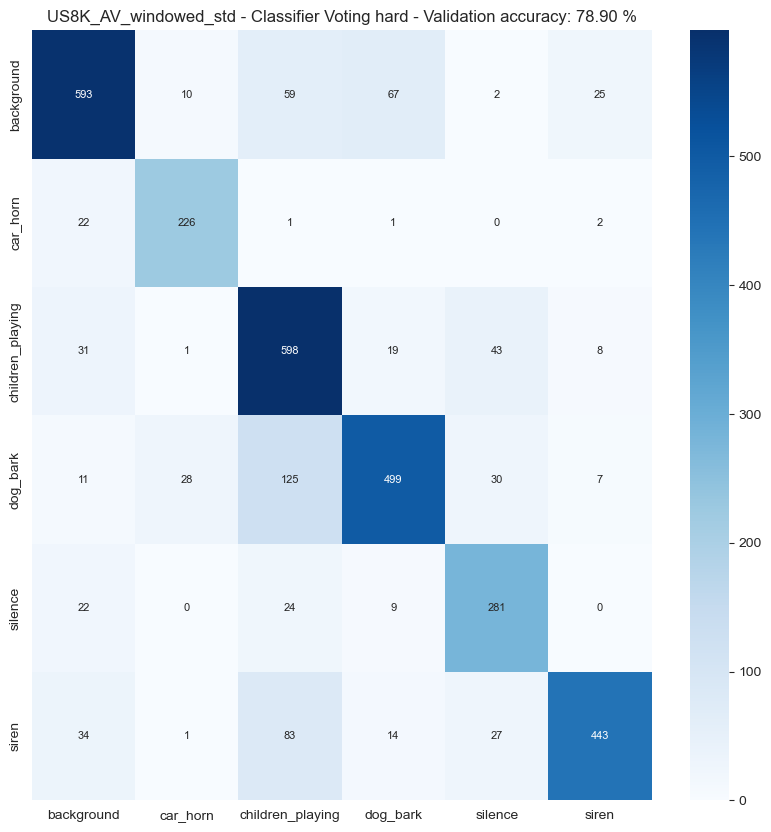

In [190]:
simple_conf_matrix(y_val, 
                   votingHard_c_saved_predict_val, 
                   nom_classes,
                   'Voting hard',
                   votingHard_c_saved_val_class_report_acc)

In [191]:
voting_clf_soft_saved.fit(X_train, y_train)

VotingClassifier(estimators=[('Naïves Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, degree=9, kernel='linear',
                                  probability=True, random_state=1000,
                                  verbose=True)),
                             ('Logistic regression',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga', verbose=10)),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=20, n_jobs=-1,
                                                   n_neighbors=3))],
                 n_jobs=-1, verbose=True, voting='soft')

In [192]:
t_srt = time.process_time_ns()

votingSoft_c_saved_predict_val = voting_clf_soft_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

Processing time: 13968,7500 ms


In [193]:
votingSoft_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingSoft_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = False)
print(votingSoft_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.93      0.73      0.82       756
        car_horn       0.86      0.94      0.90       252
children_playing       0.70      0.88      0.78       700
        dog_bark       0.83      0.74      0.78       700
         silence       0.70      0.97      0.81       336
           siren       0.89      0.76      0.82       602

        accuracy                           0.81      3346
       macro avg       0.82      0.84      0.82      3346
    weighted avg       0.83      0.81      0.81      3346



In [194]:
votingSoft_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingSoft_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = True)
votingSoft_c_saved_val_class_report_acc = votingSoft_c_saved_val_class_report['accuracy']
votingSoft_c_saved_val_class_report_acc

0.8081291093843395

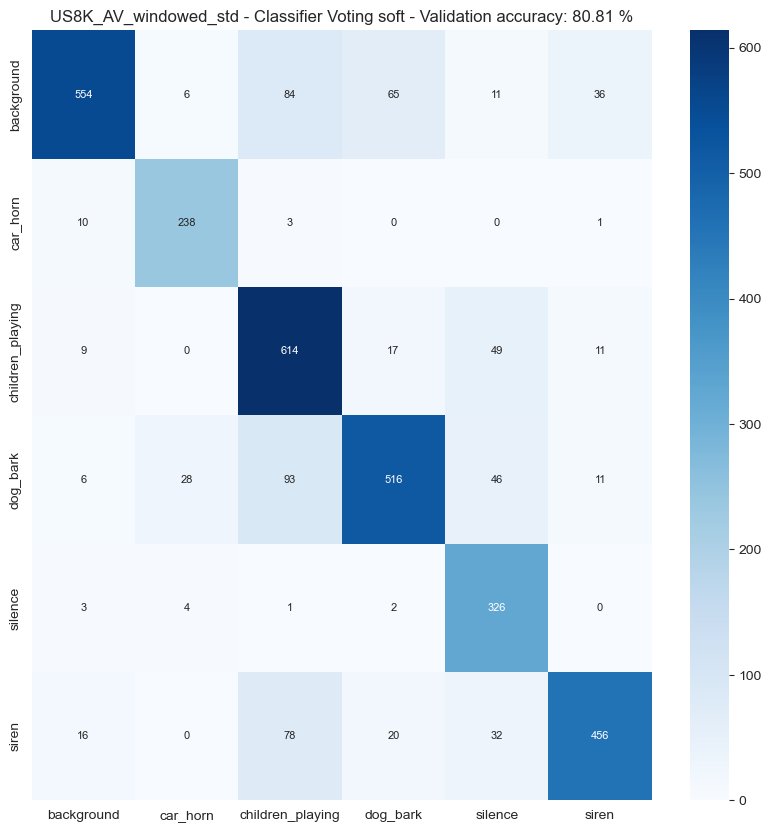

In [195]:
simple_conf_matrix(y_val, 
                   votingSoft_c_saved_predict_val, 
                   nom_classes,
                   'Voting soft',
                   votingSoft_c_saved_val_class_report_acc)

# End of notebook